# Final Project

Gabrielle Martinez
gm34308n@pace.edu   
Professor Kaltenberg  
ECO590 Data Analysis with Python and R   
2 December 2020

In this Python notebook, I will be querying the [PatentsView API](https://api.patentsview.org/patent.html) and exporting the extracted data as a single merged csv file to be cleaned in R. In R, I will clean the data and create a new variable called `Specialization` before exporting the cleaned dataset back into this notebook to create some graphs. 

## Contents
1. [Part 1: PatentsView API](http://localhost:8888/notebooks/Documents/eco590_Data_Analysis_Python_R/Assignments/final%20project/Gabrielle%20Martinez%20-%20Python.ipynb#Part-1:-PatentsView-API)
2. [Part 2: Data Cleaning](http://localhost:8888/notebooks/Documents/eco590_Data_Analysis_Python_R/Assignments/final%20project/Gabrielle%20Martinez%20-%20Python.ipynb#Part-2:-Data-Cleaning) - See `Gabrielle Martinez - R.ipynb`
3. [Part 3: Graphs](http://localhost:8888/notebooks/Documents/eco590_Data_Analysis_Python_R/Assignments/final%20project/Gabrielle%20Martinez%20-%20Python.ipynb#Part-3:-Graphs)
4. [Part 4: Regressions](http://localhost:8888/notebooks/Documents/eco590_Data_Analysis_Python_R/Assignments/final%20project/Gabrielle%20Martinez%20-%20Python.ipynb#Part-4:-Regressions) - See `Gabrielle Martinez- R.ipynb`

## Part 1: PatentsView API



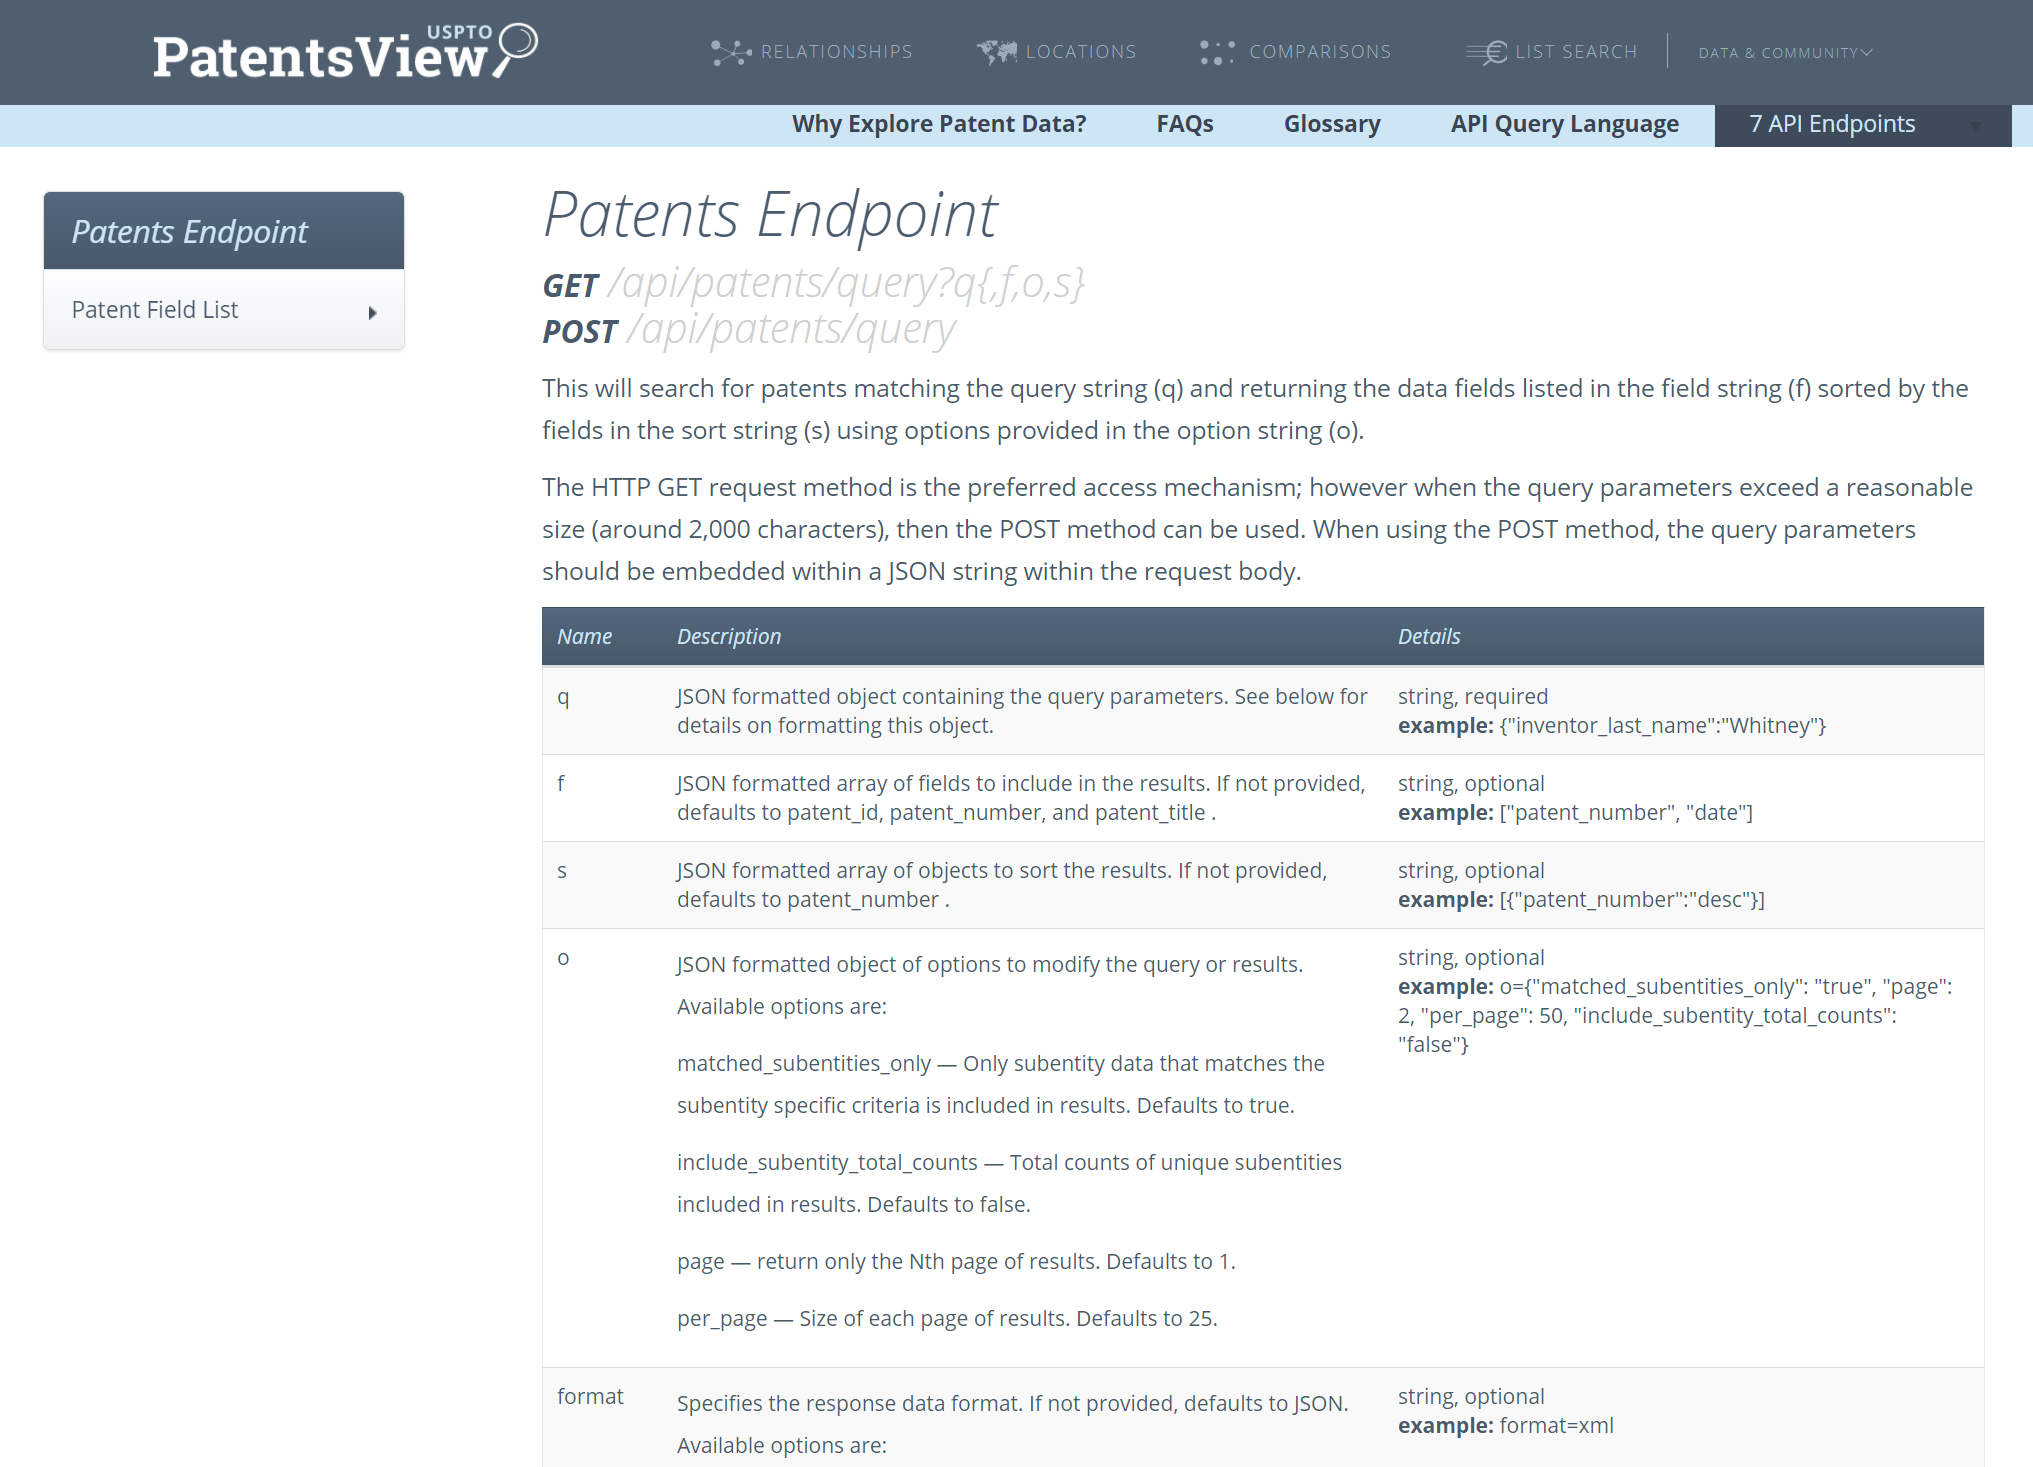

The API has 7 different "endpoints" which changes what data you end up extracting.   
    
The variables I wanted was the following:    
    
    - assignee name
    - assignee id number
    - assignee country
    - assignee state
    - number of patents under an assignee by year
    - year
    - uspc subclass/class

The assignee endpoint had a field called `year_num_patents_for_assignee` which I thought was great but it only gives the total number of patents in given year for an assignee. It does not change when I specify a uspc subclass or class. This might be useful for future research but for right now, it is not what I am looking for. Thus, I used the patents endpoint.

**Example Query URLs from the Patents Endpoint Documentation:**
> Return the patent number, processing time, and patent kind for patents granted after 2001 that have the word "international" in the abstract and have a foreign company or corporation assignee.
https://api.patentsview.org/patents/query?q={"_and":[{"_gte":{"patent_date":"2001-01-01"}},{"_text_any":{"patent_abstract":"international"}},{"_neq":{"assignee_lastknown_country":"US"}}]}&f=["patent_number","patent_processing_time","patent_kind"]

I'll be using the API to call all the patents for the following subclasses:

> 	Classes 60, 73, 123, 180, 701 and 903
	60/subclasses 272, 39.01, 516, and 698
	73/112-115
	Class 123
	180/subclasses 65.1 through 65.8
	701/subclasses 101, 103-110, 113, 123, and 29
	903/subclasses 902-927, 930, 940-948, 951, 952, and 960


I'll be specifying in the url the subclasses I want called as well as the years (anything before and during 1987). The fields I want outputed are the following:

    -"patent_year"
    -"uspc_subclass_id"
    -"assignee_type"
    -"assignee_id"
    -"inventor_id"
    -"assignee_organization"
    -"patent_number"

In [2]:
#set up
import ratelim
import tenacity
import requests
import pprint #pretty printing for json

import pandas as pd

### Create URL from a list of subclasses
We'll be querying subclasses only first. Then full classes.

*Using list comprehension makes ints to strings from: https://www.geeksforgeeks.org/python-program-to-convert-list-of-integer-to-list-of-string/*


In [3]:
#class 903/subclasses 902-927, 930, 940-948, 951, 952, and 960

#automating range 903/subclasses 902-927
x = range(902,928) #902-927
y = range(940,949) #940-948

# Using list comprehension: make ints to strings
class903 = [str(n) for n in x] 
y = [str(n) for n in y]

#extra subclasses
x=["930","951","952","960"]

#add x to y
for i in range(len(x)):
    y.append(x[i])
#print(y)

#add y to class903
for i in range(len(y)):
    class903.append(y[i])

    
for i in range(len(class903)):
    if(i==len(class903)-1):
        class903[i] = '\"903/'+ class903[i] + '\"' #add 903/ w no ',' for the last of the list
    else:
        class903[i] = '\"903/'+ class903[i] + '\",' #add 903/ and ',' for all the rest
    
print(class903)


['"903/902",', '"903/903",', '"903/904",', '"903/905",', '"903/906",', '"903/907",', '"903/908",', '"903/909",', '"903/910",', '"903/911",', '"903/912",', '"903/913",', '"903/914",', '"903/915",', '"903/916",', '"903/917",', '"903/918",', '"903/919",', '"903/920",', '"903/921",', '"903/922",', '"903/923",', '"903/924",', '"903/925",', '"903/926",', '"903/927",', '"903/940",', '"903/941",', '"903/942",', '"903/943",', '"903/944",', '"903/945",', '"903/946",', '"903/947",', '"903/948",', '"903/930",', '"903/951",', '"903/952",', '"903/960"']


In [4]:
# first part of url
url = ('https://api.patentsview.org/patents/query?' #static part
      
        'q={'
           '"_and":['     #uspc subclass id/codes hard coded
               '{"uspc_subclass_id":["60/272","60/516","60/698","73/112","73/115","73/113","73/114","701/101","701/103"'
                   ',"701/104","701/105","701/106","701/107","701/108","701/109","701/110","701/113","701/123","701/29",')

#add class 903 subclasses

for i in range(len(class903)):
    url = url + class903[i]
    
#print(url)


#add rest of url
url_p2 = (']}' 
               ',{"_lte":{"patent_date":"1987-12-31"}}' #year of patent <= 1987
            ']}'
            '&f=["patent_year","uspc_subclass_id","assignee_type","assignee_id","inventor_id","assignee_organization","patent_number","assignee_country","assignee_state"]'
            '&o={"matched_subentities_only":"true","per_page":1000}'
         )

url = url + url_p2

print(url)

https://api.patentsview.org/patents/query?q={"_and":[{"uspc_subclass_id":["60/272","60/516","60/698","73/112","73/115","73/113","73/114","701/101","701/103","701/104","701/105","701/106","701/107","701/108","701/109","701/110","701/113","701/123","701/29","903/902","903/903","903/904","903/905","903/906","903/907","903/908","903/909","903/910","903/911","903/912","903/913","903/914","903/915","903/916","903/917","903/918","903/919","903/920","903/921","903/922","903/923","903/924","903/925","903/926","903/927","903/940","903/941","903/942","903/943","903/944","903/945","903/946","903/947","903/948","903/930","903/951","903/952","903/960"]},{"_lte":{"patent_date":"1987-12-31"}}]}&f=["patent_year","uspc_subclass_id","assignee_type","assignee_id","inventor_id","assignee_organization","patent_number","assignee_country","assignee_state"]&o={"matched_subentities_only":"true","per_page":1000}


The above url has most of the subclasses except:

>Class 123  
180/subclasses 65.1 through 65.8   
60/39.01

Decimal subclasses and full classes need to be queried seperately.

### Query and Get Method

In [5]:
#get method
response = requests.get(url) 

#print any messages in case of error
print(f"{response.status_code}:{response.reason}")

#parse into json
patents = response.json()

#pretty print json
pp = pprint.PrettyPrinter(indent=1)
pp.pprint(patents)

#full subclass query = 553 patents

200:OK
{'count': 553,
 'patents': [{'assignees': [{'assignee_country': 'US',
                             'assignee_id': 'org_WLFbXEQXv0uuNglpaujt',
                             'assignee_key_id': '405316',
                             'assignee_organization': 'Robertshaw Controls '
                                                      'Company',
                             'assignee_state': 'VA',
                             'assignee_type': '2'}],
              'inventors': [{'inventor_id': '3934417-1',
                             'inventor_key_id': '321348'},
                            {'inventor_id': '3934417-2',
                             'inventor_key_id': '321349'},
                            {'inventor_id': '3934417-3',
                             'inventor_key_id': '321350'},
                            {'inventor_id': '3934417-4',
                             'inventor_key_id': '321351'}],
              'patent_number': '3934417',
              'patent_year': '1976',
 

             {'assignees': [{'assignee_country': 'US',
                             'assignee_id': 'org_9mzAdRcK21L28CuzEph8',
                             'assignee_key_id': '70547',
                             'assignee_organization': 'Cutler-Hammer, Inc.',
                             'assignee_state': 'WI',
                             'assignee_type': '2'}],
              'inventors': [{'inventor_id': '4054051-1',
                             'inventor_key_id': '450633'}],
              'patent_number': '4054051',
              'patent_year': '1977',
              'uspcs': [{'uspc_subclass_id': '60/516'}]},
             {'assignees': [{'assignee_country': 'JP',
                             'assignee_id': 'org_0eDis9QrietKKeULTT5r',
                             'assignee_key_id': '2267',
                             'assignee_organization': 'Toyota Jidosha '
                                                      'Kabushiki Kaisha',
                             'assignee_state': Non

             {'assignees': [{'assignee_country': 'US',
                             'assignee_id': 'org_6jWVXUock8hnH1uTSjxm',
                             'assignee_key_id': '47634',
                             'assignee_organization': 'The Bendix Corporation',
                             'assignee_state': 'MI',
                             'assignee_type': '2'}],
              'inventors': [{'inventor_id': '3960130-1',
                             'inventor_key_id': '356730'},
                            {'inventor_id': '3993939-2',
                             'inventor_key_id': '394483'},
                            {'inventor_id': '4114570-1',
                             'inventor_key_id': '500546'}],
              'patent_number': '4212065',
              'patent_year': '1980',
              'uspcs': [{'uspc_subclass_id': '701/104'},
                        {'uspc_subclass_id': '701/108'}]},
             {'assignees': [{'assignee_country': 'US',
                             'a

                            {'inventor_id': '4347570-4',
                             'inventor_key_id': '665844'},
                            {'inventor_id': '4347570-5',
                             'inventor_key_id': '665845'}],
              'patent_number': '4347570',
              'patent_year': '1982',
              'uspcs': [{'uspc_subclass_id': '701/105'}]},
             {'assignees': [{'assignee_country': None,
                             'assignee_id': None,
                             'assignee_key_id': None,
                             'assignee_organization': None,
                             'assignee_state': None,
                             'assignee_type': None}],
              'inventors': [{'inventor_id': '4049145-1',
                             'inventor_key_id': '446458'}],
              'patent_number': '4347907',
              'patent_year': '1982',
              'uspcs': [{'uspc_subclass_id': '903/905'},
                        {'uspc_subclass_id': '903/

              'uspcs': [{'uspc_subclass_id': '701/108'}]},
             {'assignees': [{'assignee_country': 'JP',
                             'assignee_id': 'org_5CesVQpSMaMg9i5nVfEU',
                             'assignee_key_id': '38409',
                             'assignee_organization': 'Honda Motor Co., Ltd.',
                             'assignee_state': None,
                             'assignee_type': '3'}],
              'inventors': [{'inventor_id': '4364359-3',
                             'inventor_key_id': '676741'}],
              'patent_number': '4454853',
              'patent_year': '1984',
              'uspcs': [{'uspc_subclass_id': '701/108'}]},
             {'assignees': [{'assignee_country': 'JP',
                             'assignee_id': 'org_5CesVQpSMaMg9i5nVfEU',
                             'assignee_key_id': '38409',
                             'assignee_organization': 'Honda Motor Co., Ltd.',
                             'assignee_state': None,
 

              'uspcs': [{'uspc_subclass_id': '701/105'},
                        {'uspc_subclass_id': '701/104'},
                        {'uspc_subclass_id': '701/113'}]},
             {'assignees': [{'assignee_country': 'JP',
                             'assignee_id': 'org_yUTZSCLdspe7vDSdzJ6d',
                             'assignee_key_id': '439112',
                             'assignee_organization': 'Honda Giken Kogyo '
                                                      'Kabushiki Kaisha',
                             'assignee_state': None,
                             'assignee_type': '3'}],
              'inventors': [{'inventor_id': '3945345-1',
                             'inventor_key_id': '336992'},
                            {'inventor_id': '4548181-2',
                             'inventor_key_id': '795226'}],
              'patent_number': '4590564',
              'patent_year': '1986',
              'uspcs': [{'uspc_subclass_id': '701/110'}]},
             {'a

                            {'inventor_id': '4701682-1',
                             'inventor_key_id': '896945'},
                            {'inventor_id': '4701682-5',
                             'inventor_key_id': '896946'}],
              'patent_number': '4701682',
              'patent_year': '1987',
              'uspcs': [{'uspc_subclass_id': '701/108'}]},
             {'assignees': [{'assignee_country': 'JP',
                             'assignee_id': 'org_yOSqt2KbCZQB2LRNpEKS',
                             'assignee_key_id': '436191',
                             'assignee_organization': 'Hitachi, Ltd.',
                             'assignee_state': None,
                             'assignee_type': '3'}],
              'inventors': [{'inventor_id': '3939811-1',
                             'inventor_key_id': '329246'},
                            {'inventor_id': '3953692-1',
                             'inventor_key_id': '348411'},
                            {'inven

In [6]:
#lets looks at the structure of the json
print(patents['patents'][0]) #<-one instance

{'patent_year': '1976', 'patent_number': '3934417', 'inventors': [{'inventor_id': '3934417-1', 'inventor_key_id': '321348'}, {'inventor_id': '3934417-2', 'inventor_key_id': '321349'}, {'inventor_id': '3934417-3', 'inventor_key_id': '321350'}, {'inventor_id': '3934417-4', 'inventor_key_id': '321351'}], 'assignees': [{'assignee_type': '2', 'assignee_id': 'org_WLFbXEQXv0uuNglpaujt', 'assignee_organization': 'Robertshaw Controls Company', 'assignee_country': 'US', 'assignee_state': 'VA', 'assignee_key_id': '405316'}], 'uspcs': [{'uspc_subclass_id': '60/516'}]}


In [10]:
#loop through patents to get all patent instances
patent = []
years = []
assignees = []
inventors = []
assignee_id = []
uspcs = []

#need these to have similar columns to merge dfs
a_name=[]
p_num = []
p_num_2=[]

#NOTE: change assignee_organization to assignee_id

#first level data
for k in range(len(patents['patents'])): #loop thru patents and append
    years.append(patents['patents'][k]['patent_year'])
    uspcs.append(patents['patents'][k]['uspcs'][0]['uspc_subclass_id'])
    
    
    a_name.append(patents['patents'][k]['assignees'][0]['assignee_organization'])
    p_num.append(patents['patents'][k]['patent_number'])
    

    #assignee info is nested so I need another for loop to get to it
    #second level data
    for i in range(len(patents['patents'][k]['assignees'])): #loop thru assignees and append
        assignees.append(patents['patents'][k]['assignees'][i])
        assignees_df = pd.DataFrame(assignees) #assignee dataframe
            
        patent.append(patents['patents'][k]['patent_number'])
        
        
        #this for loop is to make the assignees repeat and correspond with the inventor ids
        #put assignees and inventors on the same level
        for x in range(len(patents['patents'][k]['inventors'])): #eww three for loops. n^3 complexity >.<
            
            inventors.append(patents['patents'][k]['inventors'][x]) #append inventor data
            inventors_df = pd.DataFrame(inventors) 
            assignee_id.append(patents['patents'][k]['assignees'][i]['assignee_organization']) #change this to assignee_id 
            
            p_num_2.append(patents['patents'][k]['patent_number']) #things are repeating so I needed another list to keep up with this loop
           
        

#print(patents['patents'][k]['assignees'][0]['assignee_organization'])        

#add columns to dataframes
inventors_df["assignee_organization"]=assignee_id
inventors_df["patent_number"]=p_num_2
inventors_df  



inventor_id inventor_key_id  \
0      3934417-1          321348   
1      3934417-2          321349   
2      3934417-3          321350   
3      3934417-4          321351   
4      3937017-1          325169   
...          ...             ...   
1273   3955273-1          350548   
1274   3980832-1          380527   
1275   4274141-1          616966   
1276   4190027-4          557517   
1277   4274141-1          616966   

                                  assignee_organization patent_number  
0                           Robertshaw Controls Company       3934417  
1                           Robertshaw Controls Company       3934417  
2                           Robertshaw Controls Company       3934417  
3                           Robertshaw Controls Company       3934417  
4     Maschinenfabrik Augsburg-Nurnberg Aktiengesell...       3937017  
...                                                 ...           ...  
1273                                      Hitachi, Ltd.       RE32140  
1274                                      Hitachi, Ltd.       RE32140  
1275                                      Hitachi, Ltd.       RE32140  
1276                                      Hitachi, Ltd.       RE32156  
1277                                      Hitachi, Ltd.       RE32156  

[1278 rows x 4 columns]

In [11]:
#create years_df
years_df = pd.DataFrame(years)

#add columns to dataframe
years_df["patent_number"]=p_num
years_df["uspc_subclass_id"]=uspcs
years_df["assignee_organization"]=a_name
years_df


0 patent_number uspc_subclass_id  \
0    1976       3934417           60/516   
1    1976       3937017           60/516   
2    1976       3953715          701/123   
3    1976       3953716          701/123   
4    1976       3956895           60/516   
..    ...           ...              ...   
548  1978       RE29741          701/110   
549  1985       RE31906          701/108   
550  1985       RE32030          701/110   
551  1986       RE32140          701/103   
552  1986       RE32156          701/108   

                                 assignee_organization  
0                          Robertshaw Controls Company  
1    Maschinenfabrik Augsburg-Nurnberg Aktiengesell...  
2    Societe des Procedes Modernes d'Injection Sopromi  
3    Agence Nationale de Valorisation de la Recherc...  
4    The United States of America as represented by...  
..                                                 ...  
548                              Nippondenso Co., Ltd.  
549                                      Hitachi, Ltd.  
550                             Nissan Motor Co., Ltd.  
551                                      Hitachi, Ltd.  
552                                      Hitachi, Ltd.  

[553 rows x 4 columns]

In [12]:
#add patent id
assignees_df["patent_number"]=patent
assignees_df

assignee_type               assignee_id  \
0               2  org_WLFbXEQXv0uuNglpaujt   
1               3  org_d7Cgs8GkaSDEwmfFOL1Z   
2               3  org_sojILSfE8Of4IhJtoUvH   
3               3  org_Z8mWQfh54whRqC1GqzOM   
4               7  org_7IZPx0no0y4uuAMGwkei   
..            ...                       ...   
574             3  org_Qk7ZY773gg0j4nmTULIb   
575             3  org_yOSqt2KbCZQB2LRNpEKS   
576             3  org_5vNXv1xWJ6aH9VmhCVri   
577             3  org_yOSqt2KbCZQB2LRNpEKS   
578             3  org_yOSqt2KbCZQB2LRNpEKS   

                                 assignee_organization assignee_country  \
0                          Robertshaw Controls Company               US   
1    Maschinenfabrik Augsburg-Nurnberg Aktiengesell...               DT   
2    Firma Motoren-Werke Mannheim Aktiengesellschaf...               DE   
3    Societe des Procedes Modernes d'Injection Sopromi               FR   
4    Agence Nationale de Valorisation de la Recherc...               FR   
..                                                 ...              ...   
574                              Nippondenso Co., Ltd.               JP   
575                                      Hitachi, Ltd.               JP   
576                             Nissan Motor Co., Ltd.               JP   
577                                      Hitachi, Ltd.               JP   
578                                      Hitachi, Ltd.               JP   

    assignee_state assignee_key_id patent_number  
0               VA          405316       3934417  
1             None          119492       3937017  
2             None          347790       3937017  
3             None          443684       3953715  
4             None           54873       3953716  
..             ...             ...           ...  
574           None          316278       RE29741  
575           None          436191       RE31906  
576           None           43058       RE32030  
577           None          436191       RE32140  
578           None          436191       RE32156  

[579 rows x 7 columns]

For these subclasses

- years_df 553 rows   
- inventors_df 1278 rows   
- assignees_df 579 rows  

### Get Inventor Counts and Merge dataframes

*rename columns: https://note.nkmk.me/en/python-pandas-dataframe-rename/*

In [19]:
#get number of inventors per assignee

#groupby inventor 
inventor_groupby = inventors_df.groupby(['assignee_organization','patent_number']).count()
inventor_groupby = inventor_groupby.drop(['inventor_key_id'],1)
inventor_groupby

#merge w assignees_df
merge1 = pd.merge(assignees_df,inventor_groupby,left_on=['assignee_organization','patent_number'], right_on=['assignee_organization','patent_number'], how='left').drop_duplicates()
merge1 = merge1.rename(columns={'inventor_id':'num_inventors'}) #rename col
merge1

assignee_type               assignee_id  \
0               2  org_WLFbXEQXv0uuNglpaujt   
1               3  org_d7Cgs8GkaSDEwmfFOL1Z   
2               3  org_sojILSfE8Of4IhJtoUvH   
3               3  org_Z8mWQfh54whRqC1GqzOM   
4               7  org_7IZPx0no0y4uuAMGwkei   
..            ...                       ...   
574             3  org_Qk7ZY773gg0j4nmTULIb   
575             3  org_yOSqt2KbCZQB2LRNpEKS   
576             3  org_5vNXv1xWJ6aH9VmhCVri   
577             3  org_yOSqt2KbCZQB2LRNpEKS   
578             3  org_yOSqt2KbCZQB2LRNpEKS   

                                 assignee_organization assignee_country  \
0                          Robertshaw Controls Company               US   
1    Maschinenfabrik Augsburg-Nurnberg Aktiengesell...               DT   
2    Firma Motoren-Werke Mannheim Aktiengesellschaf...               DE   
3    Societe des Procedes Modernes d'Injection Sopromi               FR   
4    Agence Nationale de Valorisation de la Recherc...               FR   
..                                                 ...              ...   
574                              Nippondenso Co., Ltd.               JP   
575                                      Hitachi, Ltd.               JP   
576                             Nissan Motor Co., Ltd.               JP   
577                                      Hitachi, Ltd.               JP   
578                                      Hitachi, Ltd.               JP   

    assignee_state assignee_key_id patent_number  num_inventors  
0               VA          405316       3934417            4.0  
1             None          119492       3937017            3.0  
2             None          347790       3937017            3.0  
3             None          443684       3953715            1.0  
4             None           54873       3953716            1.0  
..             ...             ...           ...            ...  
574           None          316278       RE29741            2.0  
575           None          436191       RE31906            3.0  
576           None           43058       RE32030            2.0  
577           None          436191       RE32140            3.0  
578           None          436191       RE32156            2.0  

[579 rows x 8 columns]

In [21]:
#merge patents-years df w/ assignees_df
merged1 = pd.merge(years_df,merge1, left_on=['assignee_organization','patent_number'], right_on=['assignee_organization','patent_number'], how='left').drop_duplicates()

#rename first col to year
merged1 = merged1.rename(columns={0: 'years'})

merged1

years patent_number uspc_subclass_id  \
0    1976       3934417           60/516   
1    1976       3937017           60/516   
2    1976       3953715          701/123   
3    1976       3953716          701/123   
4    1976       3956895           60/516   
..    ...           ...              ...   
548  1978       RE29741          701/110   
549  1985       RE31906          701/108   
550  1985       RE32030          701/110   
551  1986       RE32140          701/103   
552  1986       RE32156          701/108   

                                 assignee_organization assignee_type  \
0                          Robertshaw Controls Company             2   
1    Maschinenfabrik Augsburg-Nurnberg Aktiengesell...             3   
2    Societe des Procedes Modernes d'Injection Sopromi             3   
3    Agence Nationale de Valorisation de la Recherc...             7   
4    The United States of America as represented by...             6   
..                                                 ...           ...   
548                              Nippondenso Co., Ltd.             3   
549                                      Hitachi, Ltd.             3   
550                             Nissan Motor Co., Ltd.             3   
551                                      Hitachi, Ltd.             3   
552                                      Hitachi, Ltd.             3   

                  assignee_id assignee_country assignee_state assignee_key_id  \
0    org_WLFbXEQXv0uuNglpaujt               US             VA          405316   
1    org_d7Cgs8GkaSDEwmfFOL1Z               DT           None          119492   
2    org_Z8mWQfh54whRqC1GqzOM               FR           None          443684   
3    org_7IZPx0no0y4uuAMGwkei               FR           None           54873   
4    org_aaQSmBL5udG3Y90mfh5v               US             DC           76455   
..                        ...              ...            ...             ...   
548  org_Qk7ZY773gg0j4nmTULIb               JP           None          316278   
549  org_yOSqt2KbCZQB2LRNpEKS               JP           None          436191   
550  org_5vNXv1xWJ6aH9VmhCVri               JP           None           43058   
551  org_yOSqt2KbCZQB2LRNpEKS               JP           None          436191   
552  org_yOSqt2KbCZQB2LRNpEKS               JP           None          436191   

     num_inventors  
0              4.0  
1              3.0  
2              1.0  
3              1.0  
4              4.0  
..             ...  
548            2.0  
549            3.0  
550            2.0  
551            3.0  
552            2.0  

[553 rows x 10 columns]

### Query full classes
This is where things get dicy.

The previous query was missing:

>Class 123  
180/subclasses 65.1 through 65.8 (I kept the whole class)  
60/39.01 subclass (I dropped this subclass)  

Decimal subclasses are hard to query so I'm going to filter them out of the big classes. My data set right now has 553 patents. That's going to explode once I add full classes. Class 123 is especially big.

In [46]:
#hard coding urls for the two classes

url180 = ('https://api.patentsview.org/patents/query?' #static part
      
        'q={'
           '"_and":[' '{"uspc_mainclass_id":"180"}' #query uspc_mainclass_id
                    ',{"_lte":{"patent_date":"1987-12-31"}}' #year of patent <= 1987
            ']}'
        #fields
        '&f=["patent_year","uspc_subclass_id","assignee_type","assignee_id","inventor_id","assignee_organization","patent_number","assignee_country","assignee_state"]'
        '&o={"matched_subentities_only":"true","per_page":6500}' #ran 5000 once for total_patents - wouldn't recommend to do again, try 1000
      ) 

url123 = ('https://api.patentsview.org/patents/query?' #static part
      
        'q={'
           '"_and":[' '{"uspc_mainclass_id":"123"}' #query uspc_mainclass_id
                    ',{"_lte":{"patent_date":"1987-12-31"}}' #year of patent <= 1987
            ']}'
        #fields
        '&f=["patent_year","uspc_subclass_id","assignee_type","assignee_id","inventor_id","assignee_organization","patent_number","assignee_country","assignee_state"]'
        '&o={"matched_subentities_only":"true","per_page":5000,"page":' #ran 5000 once for total_patents - wouldn't recommend to do again, try 1000
      ) 


#looping page numbers
url_list=[]
pages = range(1,4) #lets see how many instances 8 pages get me
page = [str(n) for n in pages] 

for i in page:
    url_list.append(url123 + i + '}')

# url_list[1]

for i in url_list:
    print(i)    


https://api.patentsview.org/patents/query?q={"_and":[{"uspc_mainclass_id":"123"},{"_lte":{"patent_date":"1987-12-31"}}]}&f=["patent_year","uspc_subclass_id","assignee_type","assignee_id","inventor_id","assignee_organization","patent_number","assignee_country","assignee_state"]&o={"matched_subentities_only":"true","per_page":5000,"page":1}
https://api.patentsview.org/patents/query?q={"_and":[{"uspc_mainclass_id":"123"},{"_lte":{"patent_date":"1987-12-31"}}]}&f=["patent_year","uspc_subclass_id","assignee_type","assignee_id","inventor_id","assignee_organization","patent_number","assignee_country","assignee_state"]&o={"matched_subentities_only":"true","per_page":5000,"page":2}
https://api.patentsview.org/patents/query?q={"_and":[{"uspc_mainclass_id":"123"},{"_lte":{"patent_date":"1987-12-31"}}]}&f=["patent_year","uspc_subclass_id","assignee_type","assignee_id","inventor_id","assignee_organization","patent_number","assignee_country","assignee_state"]&o={"matched_subentities_only":"true","pe

### Query Class 180 alone

In [32]:
#get method
response = requests.get(url180) 

#print any messages in case of error
print(f"{response.status_code}:{response.reason}")

#parse into json
patents = response.json()

#pretty print json
pp = pprint.PrettyPrinter(indent=1)
pp.pprint(patents)

#6305 patents

200:OK
{'count': 6305,
 'patents': [{'assignees': [{'assignee_country': 'US',
                             'assignee_id': 'org_SYcnyWaFzGa0JI9AgdeV',
                             'assignee_key_id': '352450',
                             'assignee_organization': 'Monroe Auto Equipment '
                                                      'Company',
                             'assignee_state': 'MI',
                             'assignee_type': '2'}],
              'inventors': [{'inventor_id': '3930547-1',
                             'inventor_key_id': '314957'}],
              'patent_number': '3930547',
              'patent_year': '1976',
              'uspcs': [{'uspc_subclass_id': '180/182'}]},
             {'assignees': [{'assignee_country': None,
                             'assignee_id': None,
                             'assignee_key_id': None,
                             'assignee_organization': None,
                             'assignee_state': None,
               

             {'assignees': [{'assignee_country': 'JA',
                             'assignee_id': 'org_5vNXv1xWJ6aH9VmhCVri',
                             'assignee_key_id': '43058',
                             'assignee_organization': 'Nissan Motor Co., Ltd.',
                             'assignee_state': None,
                             'assignee_type': '3'}],
              'inventors': [{'inventor_id': '3939940-1',
                             'inventor_key_id': '329437'},
                            {'inventor_id': '3939940-2',
                             'inventor_key_id': '329438'}],
              'patent_number': '3939940',
              'patent_year': '1976',
              'uspcs': [{'uspc_subclass_id': '180/269'}]},
             {'assignees': [{'assignee_country': 'JA',
                             'assignee_id': 'org_5vNXv1xWJ6aH9VmhCVri',
                             'assignee_key_id': '43058',
                             'assignee_organization': 'Nissan Motor Co., Lt

              'inventors': [{'inventor_id': '3949784-1',
                             'inventor_key_id': '343085'},
                            {'inventor_id': '3949784-2',
                             'inventor_key_id': '343086'}],
              'patent_number': '3949784',
              'patent_year': '1976',
              'uspcs': [{'uspc_subclass_id': '180/121'},
                        {'uspc_subclass_id': '180/125'}]},
             {'assignees': [{'assignee_country': 'US',
                             'assignee_id': 'org_pDk0VhqxpSgeexoQra8Q',
                             'assignee_key_id': '298496',
                             'assignee_organization': 'Caterpillar Tractor Co.',
                             'assignee_state': 'IL',
                             'assignee_type': '2'}],
              'inventors': [{'inventor_id': '3949823-1',
                             'inventor_key_id': '343131'}],
              'patent_number': '3949823',
              'patent_year': '1976',
    

                            {'assignee_country': 'US',
                             'assignee_id': 'per_N5vk9wTWOJpAITYB6i8h',
                             'assignee_key_id': '485869',
                             'assignee_organization': None,
                             'assignee_state': 'NY',
                             'assignee_type': '4'}],
              'inventors': [{'inventor_id': '3964564-1',
                             'inventor_key_id': '361967'}],
              'patent_number': '3964564',
              'patent_year': '1976',
              'uspcs': [{'uspc_subclass_id': '180/219'},
                        {'uspc_subclass_id': '180/322'}]},
             {'assignees': [{'assignee_country': 'US',
                             'assignee_id': 'org_TtvozzoyiVfAW9s9IBjv',
                             'assignee_key_id': '365043',
                             'assignee_organization': 'John Blue Company '
                                                      'Division of '
        

                             'assignee_organization': None,
                             'assignee_state': None,
                             'assignee_type': None}],
              'inventors': [{'inventor_id': '3980150-1',
                             'inventor_key_id': '379718'}],
              'patent_number': '3980150',
              'patent_year': '1976',
              'uspcs': [{'uspc_subclass_id': '180/209'}]},
             {'assignees': [{'assignee_country': 'JA',
                             'assignee_id': 'org_1tuA2IrlGKNxtqnXQt8x',
                             'assignee_key_id': '13119',
                             'assignee_organization': 'Kubota Tekko Kabushiki '
                                                      'Kaisha',
                             'assignee_state': None,
                             'assignee_type': '3'}],
              'inventors': [{'inventor_id': '3964585-1',
                             'inventor_key_id': '361988'},
                            

              'uspcs': [{'uspc_subclass_id': '180/206.1'},
                        {'uspc_subclass_id': '180/206.4'},
                        {'uspc_subclass_id': '180/220'}]},
             {'assignees': [{'assignee_country': 'FR',
                             'assignee_id': 'org_uYjf02PpYthbS6FI3OvG',
                             'assignee_key_id': '382002',
                             'assignee_organization': 'Societe des '
                                                      'Accumulateurs Fixes et '
                                                      'de Traction',
                             'assignee_state': None,
                             'assignee_type': '3'}],
              'inventors': [{'inventor_id': '3960599-1',
                             'inventor_key_id': '357313'}],
              'patent_number': '3991844',
              'patent_year': '1976',
              'uspcs': [{'uspc_subclass_id': '180/68.5'}]},
             {'assignees': [{'assignee_country': None,
   

              'uspcs': [{'uspc_subclass_id': '180/271'},
                        {'uspc_subclass_id': '180/315'}]},
             {'assignees': [{'assignee_country': 'JA',
                             'assignee_id': 'org_AWJtrc4zxt2k6ERLmrw8',
                             'assignee_key_id': '86684',
                             'assignee_organization': 'Yamaha Hatsudoki '
                                                      'Kabushiki Kaisha',
                             'assignee_state': None,
                             'assignee_type': '3'}],
              'inventors': [{'inventor_id': '3970164-1',
                             'inventor_key_id': '368563'},
                            {'inventor_id': '4008777-1',
                             'inventor_key_id': '409190'}],
              'patent_number': '4008777',
              'patent_year': '1977',
              'uspcs': [{'uspc_subclass_id': '180/182'},
                        {'uspc_subclass_id': '180/68.4'}]},
             {'as

             {'assignees': [{'assignee_country': None,
                             'assignee_id': None,
                             'assignee_key_id': None,
                             'assignee_organization': None,
                             'assignee_state': None,
                             'assignee_type': None}],
              'inventors': [{'inventor_id': '4022146-1',
                             'inventor_key_id': '421951'}],
              'patent_number': '4022146',
              'patent_year': '1977',
              'uspcs': [{'uspc_subclass_id': '180/273'}]},
             {'assignees': [{'assignee_country': 'FR',
                             'assignee_id': 'org_ZZma7l7YtAfV18tODkNk',
                             'assignee_key_id': '456266',
                             'assignee_organization': 'Societe Anonyme '
                                                      'Secmafer',
                             'assignee_state': None,
                             'assignee_typ

              'patent_number': '4037429',
              'patent_year': '1977',
              'uspcs': [{'uspc_subclass_id': '180/233'}]},
             {'assignees': [{'assignee_country': 'US',
                             'assignee_id': 'org_ZRqNxYUHBhiuYcVuRnoi',
                             'assignee_key_id': '452507',
                             'assignee_organization': 'EATON CORPORATION',
                             'assignee_state': 'OH',
                             'assignee_type': '2'}],
              'inventors': [{'inventor_id': '4033377-1',
                             'inventor_key_id': '432339'}],
              'patent_number': '4037620',
              'patent_year': '1977',
              'uspcs': [{'uspc_subclass_id': '180/403'}]},
             {'assignees': [{'assignee_country': None,
                             'assignee_id': None,
                             'assignee_key_id': None,
                             'assignee_organization': None,
                      

              'patent_year': '1977',
              'uspcs': [{'uspc_subclass_id': '180/297'},
                        {'uspc_subclass_id': '180/6.48'},
                        {'uspc_subclass_id': '180/242'},
                        {'uspc_subclass_id': '180/298'},
                        {'uspc_subclass_id': '180/307'}]},
             {'assignees': [{'assignee_country': None,
                             'assignee_id': None,
                             'assignee_key_id': None,
                             'assignee_organization': None,
                             'assignee_state': None,
                             'assignee_type': None}],
              'inventors': [{'inventor_id': '4049073-1',
                             'inventor_key_id': '446407'}],
              'patent_number': '4049073',
              'patent_year': '1977',
              'uspcs': [{'uspc_subclass_id': '180/283'}]},
             {'assignees': [{'assignee_country': 'FR',
                             'assignee_

              'uspcs': [{'uspc_subclass_id': '180/428'}]},
             {'assignees': [{'assignee_country': 'CA',
                             'assignee_id': 'org_x0PsAObsHBGDlpl7YrzD',
                             'assignee_key_id': '412374',
                             'assignee_organization': 'Eaton Yale Ltd.',
                             'assignee_state': None,
                             'assignee_type': '3'}],
              'inventors': [{'inventor_id': '4064956-1',
                             'inventor_key_id': '460020'}],
              'patent_number': '4064956',
              'patent_year': '1977',
              'uspcs': [{'uspc_subclass_id': '180/24.5'},
                        {'uspc_subclass_id': '180/383'}]},
             {'assignees': [{'assignee_country': None,
                             'assignee_id': None,
                             'assignee_key_id': None,
                             'assignee_organization': None,
                             'assignee_state'

                             'assignee_state': 'IL',
                             'assignee_type': '2'}],
              'inventors': [{'inventor_id': '3995696-2',
                             'inventor_key_id': '396222'},
                            {'inventor_id': '4077490-1',
                             'inventor_key_id': '470568'}],
              'patent_number': '4077490',
              'patent_year': '1978',
              'uspcs': [{'uspc_subclass_id': '180/423'},
                        {'uspc_subclass_id': '180/6.3'}]},
             {'assignees': [{'assignee_country': 'FR',
                             'assignee_id': 'org_BWVUa7Qh6g0SirEGRS3h',
                             'assignee_key_id': '101438',
                             'assignee_organization': 'Saxby',
                             'assignee_state': None,
                             'assignee_type': '3'}],
              'inventors': [{'inventor_id': '4077535-1',
                             'inventor_key_id': '470601

                             'inventor_key_id': '481312'}],
              'patent_number': '4090577',
              'patent_year': '1978',
              'uspcs': [{'uspc_subclass_id': '180/243'},
                        {'uspc_subclass_id': '180/60'},
                        {'uspc_subclass_id': '180/65.21'},
                        {'uspc_subclass_id': '180/65.225'},
                        {'uspc_subclass_id': '180/65.285'},
                        {'uspc_subclass_id': '180/65.29'}]},
             {'assignees': [{'assignee_country': 'JA',
                             'assignee_id': 'org_tGYhXgQw89JQ716BUsMH',
                             'assignee_key_id': '358923',
                             'assignee_organization': 'Kabushiki Kaisha Toyota '
                                                      'Jidoshokki',
                             'assignee_state': None,
                             'assignee_type': '3'}],
              'inventors': [{'inventor_id': '4008779-1',
           

              'inventors': [{'inventor_id': '4105086-1',
                             'inventor_key_id': '492972'},
                            {'inventor_id': '4105086-2',
                             'inventor_key_id': '492973'},
                            {'inventor_id': '4105086-3',
                             'inventor_key_id': '492974'}],
              'patent_number': '4105086',
              'patent_year': '1978',
              'uspcs': [{'uspc_subclass_id': '180/410'},
                        {'uspc_subclass_id': '180/401'}]},
             {'assignees': [{'assignee_country': 'GB',
                             'assignee_id': 'org_zUtDRPHWYggKezLJuPsf',
                             'assignee_key_id': '453921',
                             'assignee_organization': 'Clayton Dewandre '
                                                      'Company Limited',
                             'assignee_state': None,
                             'assignee_type': '3'}],
              'inv

                             'inventor_key_id': '504167'}],
              'patent_number': '4119167',
              'patent_year': '1978',
              'uspcs': [{'uspc_subclass_id': '180/259'}]},
             {'assignees': [{'assignee_country': 'US',
                             'assignee_id': 'org_gAtcoPgihmNKjvJKWNLC',
                             'assignee_key_id': '164375',
                             'assignee_organization': 'BorgWarner Inc.',
                             'assignee_state': 'IL',
                             'assignee_type': '2'}],
              'inventors': [{'inventor_id': '3968704-1',
                             'inventor_key_id': '366810'}],
              'patent_number': '4119168',
              'patent_year': '1978',
              'uspcs': [{'uspc_subclass_id': '180/248'}]},
             {'assignees': [{'assignee_country': 'US',
                             'assignee_id': 'org_pDk0VhqxpSgeexoQra8Q',
                             'assignee_key_id': '298496'

                             'assignee_organization': 'Honda Giken Kogyo '
                                                      'Kabushiki Kaisha',
                             'assignee_state': None,
                             'assignee_type': '3'}],
              'inventors': [{'inventor_id': '4133193-1',
                             'inventor_key_id': '515104'},
                            {'inventor_id': '4133193-2',
                             'inventor_key_id': '515105'}],
              'patent_number': '4133193',
              'patent_year': '1979',
              'uspcs': [{'uspc_subclass_id': '180/287'}]},
             {'assignees': [{'assignee_country': 'GB',
                             'assignee_id': 'org_Y45rgG6K1nOP9ccyUznv',
                             'assignee_key_id': '427895',
                             'assignee_organization': 'British Hovercraft '
                                                      'Corporation Limited',
                             'assign

              'uspcs': [{'uspc_subclass_id': '180/428'}]},
             {'assignees': [{'assignee_country': 'US',
                             'assignee_id': 'org_pDk0VhqxpSgeexoQra8Q',
                             'assignee_key_id': '298496',
                             'assignee_organization': 'Caterpillar Tractor Co.',
                             'assignee_state': 'IL',
                             'assignee_type': '2'}],
              'inventors': [{'inventor_id': '3972398-1',
                             'inventor_key_id': '371109'},
                            {'inventor_id': '4074820-2',
                             'inventor_key_id': '468405'}],
              'patent_number': '4146248',
              'patent_year': '1979',
              'uspcs': [{'uspc_subclass_id': '180/378'}]},
             {'assignees': [{'assignee_country': 'US',
                             'assignee_id': 'org_pDk0VhqxpSgeexoQra8Q',
                             'assignee_key_id': '298496',
             

              'inventors': [{'inventor_id': '4006663-1',
                             'inventor_key_id': '407062'},
                            {'inventor_id': '4159723-2',
                             'inventor_key_id': '535214'}],
              'patent_number': '4159723',
              'patent_year': '1979',
              'uspcs': [{'uspc_subclass_id': '180/441'}]},
             {'assignees': [{'assignee_country': 'US',
                             'assignee_id': 'org_57TWP8DdNlXDF67NPtTo',
                             'assignee_key_id': '37560',
                             'assignee_organization': 'Deere & Company',
                             'assignee_state': 'IL',
                             'assignee_type': '2'}],
              'inventors': [{'inventor_id': '4159749-1',
                             'inventor_key_id': '535236'}],
              'patent_number': '4159749',
              'patent_year': '1979',
              'uspcs': [{'uspc_subclass_id': '180/308'},
             

                             'assignee_id': 'org_wjfUa8bUZK2lSCUGU8vm',
                             'assignee_key_id': '404381',
                             'assignee_organization': 'Allis-Chalmers '
                                                      'Corporation',
                             'assignee_state': 'WI',
                             'assignee_type': '2'}],
              'inventors': [{'inventor_id': '3966239-1',
                             'inventor_key_id': '363921'}],
              'patent_number': '4173259',
              'patent_year': '1979',
              'uspcs': [{'uspc_subclass_id': '180/290'}]},
             {'assignees': [{'assignee_country': 'US',
                             'assignee_id': 'org_lBbk9B9md6pliIaJ2Y3H',
                             'assignee_key_id': '238615',
                             'assignee_organization': 'Towmotor Corporation',
                             'assignee_state': 'OH',
                             'assignee_type': '2'}],

                             'assignee_organization': 'Deere & Company',
                             'assignee_state': 'IL',
                             'assignee_type': '2'}],
              'inventors': [{'inventor_id': '4177870-1',
                             'inventor_key_id': '548674'},
                            {'inventor_id': '4183419-2',
                             'inventor_key_id': '552682'}],
              'patent_number': '4183419',
              'patent_year': '1980',
              'uspcs': [{'uspc_subclass_id': '180/243'},
                        {'uspc_subclass_id': '180/14.3'},
                        {'uspc_subclass_id': '180/241'}]},
             {'assignees': [{'assignee_country': 'JP',
                             'assignee_id': 'org_5vNXv1xWJ6aH9VmhCVri',
                             'assignee_key_id': '43058',
                             'assignee_organization': 'Nissan Motor Co., Ltd.',
                             'assignee_state': None,
                  

                             'inventor_key_id': '481493'}],
              'patent_number': '4196686',
              'patent_year': '1980',
              'uspcs': [{'uspc_subclass_id': '180/120'},
                        {'uspc_subclass_id': '180/126'}]},
             {'assignees': [{'assignee_country': 'US',
                             'assignee_id': 'org_5EOe5KemY3Qx7Gr7dlJQ',
                             'assignee_key_id': '38960',
                             'assignee_organization': 'General Motors '
                                                      'Corporation',
                             'assignee_state': 'MI',
                             'assignee_type': '2'}],
              'inventors': [{'inventor_id': '4196774-1',
                             'inventor_key_id': '562476'}],
              'patent_number': '4196774',
              'patent_year': '1980',
              'uspcs': [{'uspc_subclass_id': '180/68.4'}]},
             {'assignees': [{'assignee_country': None,
   

              'patent_number': '4212363',
              'patent_year': '1980',
              'uspcs': [{'uspc_subclass_id': '180/19.3'}]},
             {'assignees': [{'assignee_country': 'US',
                             'assignee_id': 'org_57TWP8DdNlXDF67NPtTo',
                             'assignee_key_id': '37560',
                             'assignee_organization': 'Deere & Company',
                             'assignee_state': 'IL',
                             'assignee_type': '2'}],
              'inventors': [{'inventor_id': '3931745-1',
                             'inventor_key_id': '317059'}],
              'patent_number': '4212364',
              'patent_year': '1980',
              'uspcs': [{'uspc_subclass_id': '180/19.1'}]},
             {'assignees': [{'assignee_country': None,
                             'assignee_id': None,
                             'assignee_key_id': None,
                             'assignee_organization': None,
                       

             {'assignees': [{'assignee_country': 'US',
                             'assignee_id': 'org_icOeR6vUjVNKnOf3kYqL',
                             'assignee_key_id': '194737',
                             'assignee_organization': 'Outboard Marine '
                                                      'Corporation',
                             'assignee_state': 'IL',
                             'assignee_type': '2'}],
              'inventors': [{'inventor_id': '4074669-1',
                             'inventor_key_id': '468257'},
                            {'inventor_id': '4093896-1',
                             'inventor_key_id': '483989'}],
              'patent_number': '4227132',
              'patent_year': '1980',
              'uspcs': [{'uspc_subclass_id': '180/271'}]},
             {'assignees': [{'assignee_country': 'US',
                             'assignee_id': 'org_pDk0VhqxpSgeexoQra8Q',
                             'assignee_key_id': '298496',
           

             {'assignees': [{'assignee_country': 'US',
                             'assignee_id': 'org_1HpR4ygDN803e8OeEgvv',
                             'assignee_key_id': '10313',
                             'assignee_organization': 'Amacker, Inc.',
                             'assignee_state': 'LA',
                             'assignee_type': '2'}],
              'inventors': [{'inventor_id': '4247030-1',
                             'inventor_key_id': '598393'}],
              'patent_number': '4247030',
              'patent_year': '1981',
              'uspcs': [{'uspc_subclass_id': '180/210'}]},
             {'assignees': [{'assignee_country': 'US',
                             'assignee_id': 'org_HxMeYuXsnT7fjiQPsC0I',
                             'assignee_key_id': '189988',
                             'assignee_organization': 'Atlantic Richfield '
                                                      'Company',
                             'assignee_state': 'CA',
     

                             'inventor_key_id': '607449'}],
              'patent_number': '4260037',
              'patent_year': '1981',
              'uspcs': [{'uspc_subclass_id': '180/69.22'}]},
             {'assignees': [{'assignee_country': 'AT',
                             'assignee_id': 'org_umAp3jf6X4k3gFNYYqcR',
                             'assignee_key_id': '376203',
                             'assignee_organization': 'Voest-Alpine '
                                                      'Aktiengesellschaft',
                             'assignee_state': None,
                             'assignee_type': '3'}],
              'inventors': [{'inventor_id': '4260280-1',
                             'inventor_key_id': '607610'},
                            {'inventor_id': '4260280-2',
                             'inventor_key_id': '607611'}],
              'patent_number': '4260280',
              'patent_year': '1981',
              'uspcs': [{'uspc_subclass_id': '180/2

                             'assignee_organization': None,
                             'assignee_state': None,
                             'assignee_type': None}],
              'inventors': [{'inventor_id': '4274647-1',
                             'inventor_key_id': '617348'}],
              'patent_number': '4274647',
              'patent_year': '1981',
              'uspcs': [{'uspc_subclass_id': '180/181'}]},
             {'assignees': [{'assignee_country': 'JP',
                             'assignee_id': 'org_VEdSFmHADUGZjPqAVFAo',
                             'assignee_key_id': '387164',
                             'assignee_organization': 'Kubota Corporation',
                             'assignee_state': None,
                             'assignee_type': '3'}],
              'inventors': [{'inventor_id': '4167982-2',
                             'inventor_key_id': '541323'},
                            {'inventor_id': '4274652-1',
                             'inventor

             {'assignees': [{'assignee_country': 'JP',
                             'assignee_id': 'org_AEgwmPePTmTerKjSPNXR',
                             'assignee_key_id': '78107',
                             'assignee_organization': 'Mitsubishi Jukogyo '
                                                      'Kabushiki Kaisha',
                             'assignee_state': None,
                             'assignee_type': '3'}],
              'inventors': [{'inventor_id': '4194672-3',
                             'inventor_key_id': '560896'},
                            {'inventor_id': '4194672-4',
                             'inventor_key_id': '560897'},
                            {'inventor_id': '4287405-1',
                             'inventor_key_id': '626067'},
                            {'inventor_id': '4287405-4',
                             'inventor_key_id': '626068'},
                            {'inventor_id': '4287405-5',
                             'inventor_

                             'assignee_key_id': None,
                             'assignee_organization': None,
                             'assignee_state': None,
                             'assignee_type': None}],
              'inventors': [{'inventor_id': '4304274-1',
                             'inventor_key_id': '637599'}],
              'patent_number': '4304274',
              'patent_year': '1981',
              'uspcs': [{'uspc_subclass_id': '180/271'}]},
             {'assignees': [{'assignee_country': None,
                             'assignee_id': None,
                             'assignee_key_id': None,
                             'assignee_organization': None,
                             'assignee_state': None,
                             'assignee_type': None}],
              'inventors': [{'inventor_id': '3931859-1',
                             'inventor_key_id': '317218'}],
              'patent_number': '4304313',
              'patent_year': '1981',
  

              'patent_year': '1982',
              'uspcs': [{'uspc_subclass_id': '180/271'},
                        {'uspc_subclass_id': '180/272'},
                        {'uspc_subclass_id': '180/281'},
                        {'uspc_subclass_id': '180/286'}]},
             {'assignees': [{'assignee_country': None,
                             'assignee_id': None,
                             'assignee_key_id': None,
                             'assignee_organization': None,
                             'assignee_state': None,
                             'assignee_type': None}],
              'inventors': [{'inventor_id': None, 'inventor_key_id': None}],
              'patent_number': '4319659',
              'patent_year': '1982',
              'uspcs': [{'uspc_subclass_id': '180/271'}]},
             {'assignees': [{'assignee_country': 'US',
                             'assignee_id': 'org_ZRqNxYUHBhiuYcVuRnoi',
                             'assignee_key_id': '452507',
       

                             'assignee_state': None,
                             'assignee_type': None}],
              'inventors': [{'inventor_id': '4329796-1',
                             'inventor_key_id': '654440'}],
              'patent_number': '4329796',
              'patent_year': '1982',
              'uspcs': [{'uspc_subclass_id': '180/6.58'}]},
             {'assignees': [{'assignee_country': 'US',
                             'assignee_id': 'org_UdOFl4Os9QLKy3g7f3CS',
                             'assignee_key_id': '372125',
                             'assignee_organization': 'Tyco Industries, Inc.',
                             'assignee_state': 'NJ',
                             'assignee_type': '2'}],
              'inventors': [{'inventor_id': '4329886-1',
                             'inventor_key_id': '654488'}],
              'patent_number': '4329886',
              'patent_year': '1982',
              'uspcs': [{'uspc_subclass_id': '180/337'}]},
            

                             'assignee_organization': None,
                             'assignee_state': None,
                             'assignee_type': None}],
              'inventors': [{'inventor_id': '4346303-1',
                             'inventor_key_id': '665017'}],
              'patent_number': '4346303',
              'patent_year': '1982',
              'uspcs': [{'uspc_subclass_id': '180/65.245'},
                        {'uspc_subclass_id': '180/65.285'}]},
             {'assignees': [{'assignee_country': 'DE',
                             'assignee_id': 'org_RfsqqmkbFTkrFXKfjR3X',
                             'assignee_key_id': '329040',
                             'assignee_organization': 'Daimler-Benz '
                                                      'Aktiengesellschaft',
                             'assignee_state': None,
                             'assignee_type': '3'}],
              'inventors': [{'inventor_id': '4267779-1',
                     

                             'assignee_key_id': '172641',
                             'assignee_organization': 'Ford Motor Company',
                             'assignee_state': 'MI',
                             'assignee_type': '2'}],
              'inventors': [{'inventor_id': '4359715-1',
                             'inventor_key_id': '673710'},
                            {'inventor_id': '4359715-2',
                             'inventor_key_id': '673711'}],
              'patent_number': '4359715',
              'patent_year': '1982',
              'uspcs': [{'uspc_subclass_id': '180/271'}]},
             {'assignees': [{'assignee_country': 'JP',
                             'assignee_id': 'org_yUTZSCLdspe7vDSdzJ6d',
                             'assignee_key_id': '439112',
                             'assignee_organization': 'Honda Giken Kogyo '
                                                      'Kabushiki Kaisha',
                             'assignee_state': None,
  

                             'assignee_state': 'WI',
                             'assignee_type': '2'}],
              'inventors': [{'inventor_id': '4369856-1',
                             'inventor_key_id': '680495'}],
              'patent_number': '4369856',
              'patent_year': '1983',
              'uspcs': [{'uspc_subclass_id': '180/321'}]},
             {'assignees': [{'assignee_country': None,
                             'assignee_id': None,
                             'assignee_key_id': None,
                             'assignee_organization': None,
                             'assignee_state': None,
                             'assignee_type': None}],
              'inventors': [{'inventor_id': '4370857-1',
                             'inventor_key_id': '681126'}],
              'patent_number': '4370857',
              'patent_year': '1983',
              'uspcs': [{'uspc_subclass_id': '180/165'},
                        {'uspc_subclass_id': '180/215'},
   

                             'assignee_key_id': None,
                             'assignee_organization': None,
                             'assignee_state': None,
                             'assignee_type': None}],
              'inventors': [{'inventor_id': '4121601-1',
                             'inventor_key_id': '506091'}],
              'patent_number': '4385674',
              'patent_year': '1983',
              'uspcs': [{'uspc_subclass_id': '180/402'},
                        {'uspc_subclass_id': '180/442'}]},
             {'assignees': [{'assignee_country': 'GB',
                             'assignee_id': 'org_agujCrImkh4U16fnohh9',
                             'assignee_key_id': '79260',
                             'assignee_organization': 'Associated Engineering '
                                                      'Limited',
                             'assignee_state': None,
                             'assignee_type': '3'}],
              'inventors': [{'in

              'inventors': [{'inventor_id': '4163627-2',
                             'inventor_key_id': '538112'},
                            {'inventor_id': '4399882-2',
                             'inventor_key_id': '699762'},
                            {'inventor_id': '4399882-3',
                             'inventor_key_id': '699763'}],
              'patent_number': '4399882',
              'patent_year': '1983',
              'uspcs': [{'uspc_subclass_id': '180/6.48'},
                        {'uspc_subclass_id': '180/333'}]},
             {'assignees': [{'assignee_country': None,
                             'assignee_id': None,
                             'assignee_key_id': None,
                             'assignee_organization': None,
                             'assignee_state': None,
                             'assignee_type': None}],
              'inventors': [{'inventor_id': '4118026-1',
                             'inventor_key_id': '503300'}],
            

             {'assignees': [{'assignee_country': 'US',
                             'assignee_id': 'org_EhZVPc8dlla4vdxwVf27',
                             'assignee_key_id': '138521',
                             'assignee_organization': 'TRW Inc.',
                             'assignee_state': 'OH',
                             'assignee_type': '2'}],
              'inventors': [{'inventor_id': '4276812-1',
                             'inventor_key_id': '618896'}],
              'patent_number': '4410058',
              'patent_year': '1983',
              'uspcs': [{'uspc_subclass_id': '180/423'}]},
             {'assignees': [{'assignee_country': 'JP',
                             'assignee_id': 'org_5vNXv1xWJ6aH9VmhCVri',
                             'assignee_key_id': '43058',
                             'assignee_organization': 'Nissan Motor Co., Ltd.',
                             'assignee_state': None,
                             'assignee_type': '3'}],
              'inv

              'patent_year': '1983',
              'uspcs': [{'uspc_subclass_id': '180/6.44'},
                        {'uspc_subclass_id': '180/6.7'}]},
             {'assignees': [{'assignee_country': 'DE',
                             'assignee_id': 'org_UaYpha2PEg8eTKqrDTxo',
                             'assignee_key_id': '370829',
                             'assignee_organization': 'Zahnradfabrik '
                                                      'Friedrichshafen AG',
                             'assignee_state': None,
                             'assignee_type': '3'}],
              'inventors': [{'inventor_id': '4029124-2',
                             'inventor_key_id': '428498'}],
              'patent_number': '4421010',
              'patent_year': '1983',
              'uspcs': [{'uspc_subclass_id': '180/427'}]},
             {'assignees': [{'assignee_country': 'JP',
                             'assignee_id': 'org_0eDis9QrietKKeULTT5r',
                          

             {'assignees': [{'assignee_country': 'US',
                             'assignee_id': 'org_ZRqNxYUHBhiuYcVuRnoi',
                             'assignee_key_id': '452507',
                             'assignee_organization': 'EATON CORPORATION',
                             'assignee_state': 'OH',
                             'assignee_type': '2'}],
              'inventors': [{'inventor_id': '4282749-1',
                             'inventor_key_id': '622966'}],
              'patent_number': '4432431',
              'patent_year': '1984',
              'uspcs': [{'uspc_subclass_id': '180/248'}]},
             {'assignees': [{'assignee_country': None,
                             'assignee_id': None,
                             'assignee_key_id': None,
                             'assignee_organization': None,
                             'assignee_state': None,
                             'assignee_type': None}],
              'inventors': [{'inventor_id': '4432432-

              'inventors': [{'inventor_id': '4297943-1',
                             'inventor_key_id': '633128'}],
              'patent_number': '4446941',
              'patent_year': '1984',
              'uspcs': [{'uspc_subclass_id': '180/236'},
                        {'uspc_subclass_id': '180/242'},
                        {'uspc_subclass_id': '180/415'}]},
             {'assignees': [{'assignee_country': 'US',
                             'assignee_id': 'org_vzgjEgw0fZl5GRUZYeFd',
                             'assignee_key_id': '397102',
                             'assignee_organization': 'Fail Safe Industries, '
                                                      'Inc.',
                             'assignee_state': 'FL',
                             'assignee_type': '2'}],
              'inventors': [{'inventor_id': '4058677-1',
                             'inventor_key_id': '454622'},
                            {'inventor_id': '4313641-1',
                          

                             'inventor_key_id': '651591'},
                            {'inventor_id': '4458156-3',
                             'inventor_key_id': '737260'}],
              'patent_number': '4458156',
              'patent_year': '1984',
              'uspcs': [{'uspc_subclass_id': '180/165'}]},
             {'assignees': [{'assignee_country': 'DE',
                             'assignee_id': 'org_B78shgc7jW6RYUHqaSST',
                             'assignee_key_id': '90009',
                             'assignee_organization': 'Linde '
                                                      'Aktiengesellschaft',
                             'assignee_state': None,
                             'assignee_type': '3'}],
              'inventors': [{'inventor_id': '4458485-1',
                             'inventor_key_id': '737475'}],
              'patent_number': '4458485',
              'patent_year': '1984',
              'uspcs': [{'uspc_subclass_id': '180/6.48'}]},
 

             {'assignees': [{'assignee_country': None,
                             'assignee_id': None,
                             'assignee_key_id': None,
                             'assignee_organization': None,
                             'assignee_state': None,
                             'assignee_type': None}],
              'inventors': [{'inventor_id': '4470564-1',
                             'inventor_key_id': '745126'}],
              'patent_number': '4470564',
              'patent_year': '1984',
              'uspcs': [{'uspc_subclass_id': '180/904'}]},
             {'assignees': [{'assignee_country': 'SE',
                             'assignee_id': 'org_EODjTpbIl7T0xx0Sh5GD',
                             'assignee_key_id': '141530',
                             'assignee_organization': 'Idux Industriell '
                                                      'Exploatering Aktiebolag',
                             'assignee_state': None,
                          

             {'assignees': [{'assignee_country': 'JP',
                             'assignee_id': 'org_9QlCaiSeR9ZvNlCR5MBR',
                             'assignee_key_id': '71419',
                             'assignee_organization': 'Aisin Seiki Kabushiki '
                                                      'Kaisha',
                             'assignee_state': None,
                             'assignee_type': '3'}],
              'inventors': [{'inventor_id': '3999188-1',
                             'inventor_key_id': '399650'},
                            {'inventor_id': '4241894-1',
                             'inventor_key_id': '594730'}],
              'patent_number': '4485371',
              'patent_year': '1984',
              'uspcs': [{'uspc_subclass_id': '180/6.38'},
                        {'uspc_subclass_id': '180/6.6'},
                        {'uspc_subclass_id': '180/400'}]},
             {'assignees': [{'assignee_country': None,
                          

              'inventors': [{'inventor_id': '4500970-1',
                             'inventor_key_id': '764714'}],
              'patent_number': '4500970',
              'patent_year': '1985',
              'uspcs': [{'uspc_subclass_id': '180/168'}]},
             {'assignees': [{'assignee_country': 'CA',
                             'assignee_id': 'org_5XJ3TrINtqIiaORS9hRN',
                             'assignee_key_id': '43512',
                             'assignee_organization': 'Canadian Fram Limited',
                             'assignee_state': None,
                             'assignee_type': '3'}],
              'inventors': [{'inventor_id': '4037987-1',
                             'inventor_key_id': '436554'}],
              'patent_number': '4501129',
              'patent_year': '1985',
              'uspcs': [{'uspc_subclass_id': '180/68.4'}]},
             {'assignees': [{'assignee_country': 'GB',
                             'assignee_id': 'org_gZwyJM3NNkG25F6k

              'inventors': [{'inventor_id': '4061053-2',
                             'inventor_key_id': '456715'},
                            {'inventor_id': '4513839-1',
                             'inventor_key_id': '773173'}],
              'patent_number': '4513839',
              'patent_year': '1985',
              'uspcs': [{'uspc_subclass_id': '180/253'},
                        {'uspc_subclass_id': '180/65.51'}]},
             {'assignees': [{'assignee_country': 'US',
                             'assignee_id': 'org_hzsiI0vtP0xKet6RMtPZ',
                             'assignee_key_id': '191063',
                             'assignee_organization': 'Applied Power Inc.',
                             'assignee_state': 'WI',
                             'assignee_type': '2'}],
              'inventors': [{'inventor_id': '4057126-1',
                             'inventor_key_id': '453301'},
                            {'inventor_id': '4144713-1',
                             '

             {'assignees': [{'assignee_country': 'JP',
                             'assignee_id': 'org_BgjeGVyguhbbET1HvVVT',
                             'assignee_key_id': '93709',
                             'assignee_organization': 'Mazda Motor Corporation',
                             'assignee_state': None,
                             'assignee_type': '3'}],
              'inventors': [{'inventor_id': '4368572-1',
                             'inventor_key_id': '679572'}],
              'patent_number': '4524842',
              'patent_year': '1985',
              'uspcs': [{'uspc_subclass_id': '180/400'},
                        {'uspc_subclass_id': '180/417'}]},
             {'assignees': [{'assignee_country': 'DE',
                             'assignee_id': 'org_fBnWvc4eo2o6oD8JuvdJ',
                             'assignee_key_id': '150028',
                             'assignee_organization': 'ULO-Werk Moritz Ullmann '
                                                   

                             'assignee_organization': 'Thrush Incorporated',
                             'assignee_state': None,
                             'assignee_type': '3'}],
              'inventors': [{'inventor_id': '4333545-1',
                             'inventor_key_id': '656876'}],
              'patent_number': '4537280',
              'patent_year': '1985',
              'uspcs': [{'uspc_subclass_id': '180/309'}]},
             {'assignees': [{'assignee_country': 'JP',
                             'assignee_id': 'org_yUTZSCLdspe7vDSdzJ6d',
                             'assignee_key_id': '439112',
                             'assignee_organization': 'Honda Giken Kogyo '
                                                      'Kabushiki Kaisha',
                             'assignee_state': None,
                             'assignee_type': '3'}],
              'inventors': [{'inventor_id': '4538401-1',
                             'inventor_key_id': '788919'},
      

              'inventors': [{'inventor_id': 'D243668-1',
                             'inventor_key_id': '3690774'}],
              'patent_number': '4549629',
              'patent_year': '1985',
              'uspcs': [{'uspc_subclass_id': '180/219'}]},
             {'assignees': [{'assignee_country': 'DE',
                             'assignee_id': 'org_RfsqqmkbFTkrFXKfjR3X',
                             'assignee_key_id': '329040',
                             'assignee_organization': 'Daimler-Benz '
                                                      'Aktiengesellschaft',
                             'assignee_state': None,
                             'assignee_type': '3'}],
              'inventors': [{'inventor_id': '3934899-1',
                             'inventor_key_id': '322005'},
                            {'inventor_id': '4188059-4',
                             'inventor_key_id': '556067'}],
              'patent_number': '4549762',
              'patent_year': '19

              'patent_year': '1986',
              'uspcs': [{'uspc_subclass_id': '180/90.6'}]},
             {'assignees': [{'assignee_country': 'US',
                             'assignee_id': 'org_DC3yWvOKiqEQSkHhUfB9',
                             'assignee_key_id': '121149',
                             'assignee_organization': 'Hedstrom Corporation',
                             'assignee_state': 'PA',
                             'assignee_type': '2'}],
              'inventors': [{'inventor_id': 'D250861-2',
                             'inventor_key_id': '3695517'}],
              'patent_number': '4562893',
              'patent_year': '1986',
              'uspcs': [{'uspc_subclass_id': '180/6.5'},
                        {'uspc_subclass_id': '180/22'}]},
             {'assignees': [{'assignee_country': None,
                             'assignee_id': None,
                             'assignee_key_id': None,
                             'assignee_organization': None,
   

              'inventors': [{'inventor_id': '4541301-1',
                             'inventor_key_id': '790700'},
                            {'inventor_id': '4541301-2',
                             'inventor_key_id': '790701'},
                            {'inventor_id': '4541301-3',
                             'inventor_key_id': '790702'}],
              'patent_number': '4572313',
              'patent_year': '1986',
              'uspcs': [{'uspc_subclass_id': '180/78'}]},
             {'assignees': [{'assignee_country': 'ES',
                             'assignee_id': 'org_io4jWLgFWNbHJjT9FI69',
                             'assignee_key_id': '200243',
                             'assignee_organization': 'Bendiberica S.A.',
                             'assignee_state': None,
                             'assignee_type': '3'}],
              'inventors': [{'inventor_id': '4572314-1',
                             'inventor_key_id': '811265'}],
              'patent_number': '

             {'assignees': [{'assignee_country': 'JP',
                             'assignee_id': 'org_5vNXv1xWJ6aH9VmhCVri',
                             'assignee_key_id': '43058',
                             'assignee_organization': 'Nissan Motor Co., Ltd.',
                             'assignee_state': None,
                             'assignee_type': '3'}],
              'inventors': [{'inventor_id': '3958834-2',
                             'inventor_key_id': '355076'},
                            {'inventor_id': '3980999-2',
                             'inventor_key_id': '380717'},
                            {'inventor_id': '4342279-1',
                             'inventor_key_id': '662421'},
                            {'inventor_id': '4581607-4',
                             'inventor_key_id': '817335'}],
              'patent_number': '4581607',
              'patent_year': '1986',
              'uspcs': [{'uspc_subclass_id': '180/272'}]},
             {'assignees': 

                             'assignee_type': '3'}],
              'inventors': [{'inventor_id': '4223927-1',
                             'inventor_key_id': '582159'},
                            {'inventor_id': '4486028-1',
                             'inventor_key_id': '755102'}],
              'patent_number': '4593578',
              'patent_year': '1986',
              'uspcs': [{'uspc_subclass_id': '180/428'}]},
             {'assignees': [{'assignee_country': 'JP',
                             'assignee_id': 'org_AWJtrc4zxt2k6ERLmrw8',
                             'assignee_key_id': '86684',
                             'assignee_organization': 'Yamaha Hatsudoki '
                                                      'Kabushiki Kaisha',
                             'assignee_state': None,
                             'assignee_type': '3'}],
              'inventors': [{'inventor_id': '4016945-1',
                             'inventor_key_id': '417019'},
                      

              'inventors': [{'inventor_id': '4037492-1',
                             'inventor_key_id': '436095'},
                            {'inventor_id': '4605087-2',
                             'inventor_key_id': '832756'},
                            {'inventor_id': '4605087-3',
                             'inventor_key_id': '832757'},
                            {'inventor_id': '4605087-4',
                             'inventor_key_id': '832758'}],
              'patent_number': '4605087',
              'patent_year': '1986',
              'uspcs': [{'uspc_subclass_id': '180/248'},
                        {'uspc_subclass_id': '180/233'},
                        {'uspc_subclass_id': '180/244'}]},
             {'assignees': [{'assignee_country': 'JP',
                             'assignee_id': 'org_Qk7ZY773gg0j4nmTULIb',
                             'assignee_key_id': '316278',
                             'assignee_organization': 'Nippondenso Co., Ltd.',
                   

              'uspcs': [{'uspc_subclass_id': '180/219'},
                        {'uspc_subclass_id': '180/53.5'}]},
             {'assignees': [{'assignee_country': 'JP',
                             'assignee_id': 'org_yUTZSCLdspe7vDSdzJ6d',
                             'assignee_key_id': '439112',
                             'assignee_organization': 'Honda Giken Kogyo '
                                                      'Kabushiki Kaisha',
                             'assignee_state': None,
                             'assignee_type': '3'}],
              'inventors': [{'inventor_id': '4102379-1',
                             'inventor_key_id': '490756'},
                            {'inventor_id': '4334589-2',
                             'inventor_key_id': '657553'}],
              'patent_number': '4618020',
              'patent_year': '1986',
              'uspcs': [{'uspc_subclass_id': '180/229'},
                        {'uspc_subclass_id': '180/68.1'},
                

              'patent_number': '4627657',
              'patent_year': '1986',
              'uspcs': [{'uspc_subclass_id': '180/68.6'}]},
             {'assignees': [{'assignee_country': None,
                             'assignee_id': None,
                             'assignee_key_id': None,
                             'assignee_organization': None,
                             'assignee_state': None,
                             'assignee_type': None}],
              'inventors': [{'inventor_id': '4628300-1',
                             'inventor_key_id': '848004'}],
              'patent_number': '4628300',
              'patent_year': '1986',
              'uspcs': [{'uspc_subclass_id': '180/287'},
                        {'uspc_subclass_id': '180/289'}]},
             {'assignees': [{'assignee_country': 'JP',
                             'assignee_id': 'org_yUTZSCLdspe7vDSdzJ6d',
                             'assignee_key_id': '439112',
                             'assignee

                             'inventor_key_id': '650071'}],
              'patent_number': '4637354',
              'patent_year': '1987',
              'uspcs': [{'uspc_subclass_id': '180/219'}]},
             {'assignees': [{'assignee_country': None,
                             'assignee_id': None,
                             'assignee_key_id': None,
                             'assignee_organization': None,
                             'assignee_state': None,
                             'assignee_type': None}],
              'inventors': [{'inventor_id': '4200080-1',
                             'inventor_key_id': '564832'}],
              'patent_number': '4637359',
              'patent_year': '1987',
              'uspcs': [{'uspc_subclass_id': '180/167'}]},
             {'assignees': [{'assignee_country': None,
                             'assignee_id': None,
                             'assignee_key_id': None,
                             'assignee_organization': None,
  

              'patent_year': '1987',
              'uspcs': [{'uspc_subclass_id': '180/219'},
                        {'uspc_subclass_id': '180/68.1'},
                        {'uspc_subclass_id': '180/69.24'},
                        {'uspc_subclass_id': '180/225'},
                        {'uspc_subclass_id': '180/229'}]},
             {'assignees': [{'assignee_country': 'IT',
                             'assignee_id': 'org_wsl1y3cbPpKTi2iuQlQW',
                             'assignee_key_id': '408717',
                             'assignee_organization': 'Riv-Skf Officine Di '
                                                      'Villar Perosa S.p.A.',
                             'assignee_state': None,
                             'assignee_type': '3'}],
              'inventors': [{'inventor_id': '4618130-1',
                             'inventor_key_id': '841402'}],
              'patent_number': '4648475',
              'patent_year': '1987',
              'uspcs': [{'uspc_

                             'assignee_type': '2'}],
              'inventors': [{'inventor_id': '4660671-1',
                             'inventor_key_id': '869789'},
                            {'inventor_id': '4660671-2',
                             'inventor_key_id': '869790'},
                            {'inventor_id': '4660671-3',
                             'inventor_key_id': '869791'},
                            {'inventor_id': '4660671-4',
                             'inventor_key_id': '869792'},
                            {'inventor_id': '4660671-5',
                             'inventor_key_id': '869793'},
                            {'inventor_id': '4660671-6',
                             'inventor_key_id': '869794'}],
              'patent_number': '4660671',
              'patent_year': '1987',
              'uspcs': [{'uspc_subclass_id': '180/446'},
                        {'uspc_subclass_id': '180/404'}]},
             {'assignees': [{'assignee_country': 'JP',


              'patent_number': '4669562',
              'patent_year': '1987',
              'uspcs': [{'uspc_subclass_id': '180/53.1'}]},
             {'assignees': [{'assignee_country': 'US',
                             'assignee_id': 'org_5rxhtj02I0JiA7zklrLf',
                             'assignee_key_id': '42185',
                             'assignee_organization': 'Paccar Inc',
                             'assignee_state': 'WA',
                             'assignee_type': '2'}],
              'inventors': [{'inventor_id': '4669563-1',
                             'inventor_key_id': '875836'}],
              'patent_number': '4669563',
              'patent_year': '1987',
              'uspcs': [{'uspc_subclass_id': '180/69.24'}]},
             {'assignees': [{'assignee_country': 'DE',
                             'assignee_id': 'org_rYl8az7CpE0BvQvezLyK',
                             'assignee_key_id': '337800',
                             'assignee_organization': 'Klockn

                             'inventor_key_id': '699017'},
                            {'inventor_id': '4461366-1',
                             'inventor_key_id': '739318'},
                            {'inventor_id': '4678054-2',
                             'inventor_key_id': '881572'},
                            {'inventor_id': '4678054-4',
                             'inventor_key_id': '881573'},
                            {'inventor_id': '4678054-5',
                             'inventor_key_id': '881574'}],
              'patent_number': '4678054',
              'patent_year': '1987',
              'uspcs': [{'uspc_subclass_id': '180/225'},
                        {'uspc_subclass_id': '180/219'},
                        {'uspc_subclass_id': '180/296'}]},
             {'assignees': [{'assignee_country': 'JP',
                             'assignee_id': 'org_0eDis9QrietKKeULTT5r',
                             'assignee_key_id': '2267',
                             'assignee_or

              'inventors': [{'inventor_id': '4117823-1',
                             'inventor_key_id': '503157'},
                            {'inventor_id': '4600208-1',
                             'inventor_key_id': '829546'},
                            {'inventor_id': '4690237-2',
                             'inventor_key_id': '889471'},
                            {'inventor_id': 'D274052-3',
                             'inventor_key_id': '3707541'}],
              'patent_number': '4690237',
              'patent_year': '1987',
              'uspcs': [{'uspc_subclass_id': '180/219'}]},
             {'assignees': [{'assignee_country': 'DE',
                             'assignee_id': 'org_1D9WTW1a6lIzRduU54Cc',
                             'assignee_key_id': '9256',
                             'assignee_organization': 'Dr. Ing. h.c. F. '
                                                      'Porsche '
                                                      'Aktiengesellschaft'

              'patent_year': '1987',
              'uspcs': [{'uspc_subclass_id': '180/249'}]},
             {'assignees': [{'assignee_country': 'JP',
                             'assignee_id': 'org_N0nt2ytP5bSIoagEZNut',
                             'assignee_key_id': '265171',
                             'assignee_organization': 'Fuji Jukogyo Kabushiki '
                                                      'Kaisha',
                             'assignee_state': None,
                             'assignee_type': '3'}],
              'inventors': [{'inventor_id': '4073361-2',
                             'inventor_key_id': '467096'}],
              'patent_number': '4699237',
              'patent_year': '1987',
              'uspcs': [{'uspc_subclass_id': '180/250'}]},
             {'assignees': [{'assignee_country': None,
                             'assignee_id': None,
                             'assignee_key_id': None,
                             'assignee_organization': N

                             'inventor_key_id': '900336'}],
              'patent_number': '4706770',
              'patent_year': '1987',
              'uspcs': [{'uspc_subclass_id': '180/24.2'},
                        {'uspc_subclass_id': '180/24.9'},
                        {'uspc_subclass_id': '180/24.12'},
                        {'uspc_subclass_id': '180/251'}]},
             {'assignees': [{'assignee_country': 'JP',
                             'assignee_id': 'org_5vNXv1xWJ6aH9VmhCVri',
                             'assignee_key_id': '43058',
                             'assignee_organization': 'Nissan Motor Co., Ltd.',
                             'assignee_state': None,
                             'assignee_type': '3'}],
              'inventors': [{'inventor_id': '4639676-2',
                             'inventor_key_id': '855586'},
                            {'inventor_id': '4679808-2',
                             'inventor_key_id': '882787'}],
              'patent_nu

                             'inventor_key_id': '364014'},
                            {'inventor_id': '4151902-2',
                             'inventor_key_id': '529445'},
                            {'inventor_id': '4715466-1',
                             'inventor_key_id': '906373'},
                            {'inventor_id': '4715466-2',
                             'inventor_key_id': '906374'}],
              'patent_number': '4715466',
              'patent_year': '1987',
              'uspcs': [{'uspc_subclass_id': '180/233'},
                        {'uspc_subclass_id': '180/415'}]},
             {'assignees': [{'assignee_country': 'JP',
                             'assignee_id': 'org_N0nt2ytP5bSIoagEZNut',
                             'assignee_key_id': '265171',
                             'assignee_organization': 'Fuji Jukogyo Kabushiki '
                                                      'Kaisha',
                             'assignee_state': None,
               

In [33]:
#loop through patents to get all patent instances
patent = []
years = []
assignees = []
inventors = []
assignee_id = []
uspcs = []

#need these to have similar columns to merge dfs
a_name=[]
p_num = []
p_num_2=[]

#NOTE: change assignee_organization to assignee_id

#first level data
for k in range(len(patents['patents'])): #loop thru patents and append
    years.append(patents['patents'][k]['patent_year'])
    uspcs.append(patents['patents'][k]['uspcs'][0]['uspc_subclass_id'])
    
    
    a_name.append(patents['patents'][k]['assignees'][0]['assignee_organization'])
    p_num.append(patents['patents'][k]['patent_number'])
    

    #assignee info is nested so I need another for loop to get to it
    #second level data
    for i in range(len(patents['patents'][k]['assignees'])): #loop thru assignees and append
        assignees.append(patents['patents'][k]['assignees'][i])
        assignees_df = pd.DataFrame(assignees) #assignee dataframe
            
        patent.append(patents['patents'][k]['patent_number'])
        
        
        #this for loop is to make the assignees repeat and correspond with the inventor ids
        #put assignees and inventors on the same level
        for x in range(len(patents['patents'][k]['inventors'])): #eww three for loops. n^3 complexity >.<
            
            inventors.append(patents['patents'][k]['inventors'][x]) #append inventor data
            inventors_df = pd.DataFrame(inventors) 
            assignee_id.append(patents['patents'][k]['assignees'][i]['assignee_organization']) #change this to assignee_id 
            
            p_num_2.append(patents['patents'][k]['patent_number']) #things are repeating so I needed another list to keep up with this loop
           
        

#print(patents['patents'][k]['assignees'][0]['assignee_organization'])        



In [34]:
#add columns to dataframes
inventors_df["assignee_organization"]=assignee_id
inventors_df["patent_number"]=p_num_2
inventors_df  

inventor_id inventor_key_id  \
0       3930547-1          314957   
1       3930548-1          314958   
2       3930549-1          314959   
3       3930550-1          314960   
4       3930550-2          314961   
...           ...             ...   
10676   4043227-4          441347   
10677   4467219-1          743053   
10678   4137790-1          518679   
10679   3940177-1          329740   
10680   4126209-1          509735   

                                   assignee_organization patent_number  
0                          Monroe Auto Equipment Company       3930547  
1                                                   None       3930548  
2                                Caterpillar Tractor Co.       3930549  
3      The United States of America as represented by...       3930550  
4      The United States of America as represented by...       3930550  
...                                                  ...           ...  
10676                                   Caterpillar Inc.       RE32442  
10677                                               None       RE32474  
10678                             Nissan Motor Co., Ltd.       RE32565  
10679                            Caterpillar Tractor Co.       T982002  
10680                               Towmotor Corporation       T998004  

[10681 rows x 4 columns]

In [35]:
#create years_df
years_df = pd.DataFrame(years)

#add columns to dataframe
years_df["patent_number"]=p_num
years_df["uspc_subclass_id"]=uspcs
years_df["assignee_organization"]=a_name
years_df

0 patent_number uspc_subclass_id  \
0     1976       3930547          180/182   
1     1976       3930548          180/6.5   
2     1976       3930549         180/9.48   
3     1976       3930550         180/24.8   
4     1976       3930551         180/65.6   
...    ...           ...              ...   
6300  1987       RE32442          180/9.1   
6301  1987       RE32474          180/315   
6302  1987       RE32565          180/249   
6303  1979       T982002          180/9.6   
6304  1980       T998004          180/299   

                                  assignee_organization  
0                         Monroe Auto Equipment Company  
1                                                  None  
2                               Caterpillar Tractor Co.  
3     The United States of America as represented by...  
4                                                  None  
...                                                 ...  
6300                                   Caterpillar Inc.  
6301                                               None  
6302                             Nissan Motor Co., Ltd.  
6303                            Caterpillar Tractor Co.  
6304                               Towmotor Corporation  

[6305 rows x 4 columns]

In [36]:
#add patent id
assignees_df["patent_number"]=patent
assignees_df

assignee_type               assignee_id  \
0                2  org_SYcnyWaFzGa0JI9AgdeV   
1             None                      None   
2                2  org_pDk0VhqxpSgeexoQra8Q   
3                6  org_qFTCWgGCvruWCv3yoJi7   
4             None                      None   
...            ...                       ...   
6417             2  org_dDihSMs3ctrfrNGbJaAH   
6418          None                      None   
6419             3  org_5vNXv1xWJ6aH9VmhCVri   
6420             2  org_pDk0VhqxpSgeexoQra8Q   
6421             2  org_lBbk9B9md6pliIaJ2Y3H   

                                  assignee_organization assignee_country  \
0                         Monroe Auto Equipment Company               US   
1                                                  None             None   
2                               Caterpillar Tractor Co.               US   
3     The United States of America as represented by...               US   
4                                                  None             None   
...                                                 ...              ...   
6417                                   Caterpillar Inc.               US   
6418                                               None             None   
6419                             Nissan Motor Co., Ltd.               JP   
6420                            Caterpillar Tractor Co.               US   
6421                               Towmotor Corporation               US   

     assignee_state assignee_key_id patent_number  
0                MI          352450       3930547  
1              None            None       3930548  
2                IL          298496       3930549  
3                DC          314293       3930550  
4              None            None       3930551  
...             ...             ...           ...  
6417             IL          121782       RE32442  
6418           None            None       RE32474  
6419           None           43058       RE32565  
6420             IL          298496       T982002  
6421             OH          238615       T998004  

[6422 rows x 7 columns]

### Inventor Counts and Merge dataframes

In [37]:
#get number of inventors per assignee

#groupby inventor 
inventor_groupby = inventors_df.groupby(['assignee_organization','patent_number']).count()
inventor_groupby = inventor_groupby.drop(['inventor_key_id'],1)
inventor_groupby

#merge w assignees_df
m2 = pd.merge(assignees_df,inventor_groupby,left_on=['assignee_organization','patent_number'], right_on=['assignee_organization','patent_number'], how='left').drop_duplicates()
m2 = m2.rename(columns={'inventor_id':'num_inventors'}) #rename col
m2

assignee_type               assignee_id  \
0                2  org_SYcnyWaFzGa0JI9AgdeV   
1             None                      None   
2                2  org_pDk0VhqxpSgeexoQra8Q   
3                6  org_qFTCWgGCvruWCv3yoJi7   
4             None                      None   
...            ...                       ...   
6417             2  org_dDihSMs3ctrfrNGbJaAH   
6418          None                      None   
6419             3  org_5vNXv1xWJ6aH9VmhCVri   
6420             2  org_pDk0VhqxpSgeexoQra8Q   
6421             2  org_lBbk9B9md6pliIaJ2Y3H   

                                  assignee_organization assignee_country  \
0                         Monroe Auto Equipment Company               US   
1                                                  None             None   
2                               Caterpillar Tractor Co.               US   
3     The United States of America as represented by...               US   
4                                                  None             None   
...                                                 ...              ...   
6417                                   Caterpillar Inc.               US   
6418                                               None             None   
6419                             Nissan Motor Co., Ltd.               JP   
6420                            Caterpillar Tractor Co.               US   
6421                               Towmotor Corporation               US   

     assignee_state assignee_key_id patent_number  num_inventors  
0                MI          352450       3930547            1.0  
1              None            None       3930548            NaN  
2                IL          298496       3930549            1.0  
3                DC          314293       3930550            2.0  
4              None            None       3930551            NaN  
...             ...             ...           ...            ...  
6417             IL          121782       RE32442            1.0  
6418           None            None       RE32474            NaN  
6419           None           43058       RE32565            1.0  
6420             IL          298496       T982002            1.0  
6421             OH          238615       T998004            1.0  

[6422 rows x 8 columns]

In [40]:
#merge patents-years df w/ assignees_df
merged2 = pd.merge(years_df,m2, left_on=['assignee_organization','patent_number'], right_on=['assignee_organization','patent_number'], how='left').drop_duplicates()

#rename first col to year
merged2 = merged2.rename(columns={0: 'years'})

merged2 #.drop_duplicates()

years patent_number uspc_subclass_id  \
0     1976       3930547          180/182   
1     1976       3930548          180/6.5   
2     1976       3930549         180/9.48   
3     1976       3930550         180/24.8   
4     1976       3930551         180/65.6   
...    ...           ...              ...   
6322  1987       RE32442          180/9.1   
6323  1987       RE32474          180/315   
6324  1987       RE32565          180/249   
6325  1979       T982002          180/9.6   
6326  1980       T998004          180/299   

                                  assignee_organization assignee_type  \
0                         Monroe Auto Equipment Company             2   
1                                                  None          None   
2                               Caterpillar Tractor Co.             2   
3     The United States of America as represented by...             6   
4                                                  None          None   
...                                                 ...           ...   
6322                                   Caterpillar Inc.             2   
6323                                               None          None   
6324                             Nissan Motor Co., Ltd.             3   
6325                            Caterpillar Tractor Co.             2   
6326                               Towmotor Corporation             2   

                   assignee_id assignee_country assignee_state  \
0     org_SYcnyWaFzGa0JI9AgdeV               US             MI   
1                         None             None           None   
2     org_pDk0VhqxpSgeexoQra8Q               US             IL   
3     org_qFTCWgGCvruWCv3yoJi7               US             DC   
4                         None             None           None   
...                        ...              ...            ...   
6322  org_dDihSMs3ctrfrNGbJaAH               US             IL   
6323                      None             None           None   
6324  org_5vNXv1xWJ6aH9VmhCVri               JP           None   
6325  org_pDk0VhqxpSgeexoQra8Q               US             IL   
6326  org_lBbk9B9md6pliIaJ2Y3H               US             OH   

     assignee_key_id  num_inventors  
0             352450            1.0  
1               None            NaN  
2             298496            1.0  
3             314293            2.0  
4               None            NaN  
...              ...            ...  
6322          121782            1.0  
6323            None            NaN  
6324           43058            1.0  
6325          298496            1.0  
6326          238615            1.0  

[6327 rows x 10 columns]

### Query Class 123 alone

In [47]:
#query loop
for i in range(len(url_list)): #I would have droppped this outer loop but I just re configured it to work with 

    #get method
    response = requests.get(url_list[i]) 

    #print any messages in case of error
    print(f"{response.status_code}:{response.reason}")

    #parse into json -> reassign patents var
    patents = response.json()

    #pretty print json
#     pp = pprint.PrettyPrinter(indent=1)
#     pp.pprint(patents)
    
    
    #make into df loop
    
    if(i==0): #first run, intialize -> second run append to df
        print("first run") #if statement works
        
        #lists reassigned to empty
        patent = []
        years = []
        assignees = []
        inventors = []
        assignee_id = []
        uspcs = []

        #need these to have similar columns to merge dfs
        a_name=[]
        p_num = []
        p_num_2=[]
        
        for k in range(len(patents['patents'])): #loop thru patents and append
            years.append(patents['patents'][k]['patent_year'])
        #     patent.append(patents['patents'][k]['patent_number'])
            uspcs.append(patents['patents'][k]['uspcs'][0]['uspc_subclass_id'])

            years_df = pd.DataFrame(years) #years dataframe
            a_name.append(patents['patents'][k]['assignees'][0]['assignee_organization'])
            p_num.append(patents['patents'][k]['patent_number'])

        #     assignees.append(patents['patents'][k]['assignees'])
        #     assignees_df = pd.DataFrame(assignees)

            for i in range(len(patents['patents'][k]['assignees'])): #loop thru assignees and append
                assignees.append(patents['patents'][k]['assignees'][i])
                assignees_df = pd.DataFrame(assignees) #assignee dataframe

                patent.append(patents['patents'][k]['patent_number'])

                for x in range(len(patents['patents'][k]['inventors'])): #eww 4 for loops! n^4 complexity >.<

                    inventors.append(patents['patents'][k]['inventors'][x]) #append inventor data
                    inventors_df = pd.DataFrame(inventors) 
                    assignee_id.append(patents['patents'][k]['assignees'][i]['assignee_organization']) #change this to assignee_id 

                    p_num_2.append(patents['patents'][k]['patent_number'])
                    #this for loop is to make the assignees repeat and correspond with the inventor ids


        #print(patents['patents'][k]['assignees'][0]['assignee_organization'])        

#         #add columns to dataframes
        inventors_df["assignee_organization"]=assignee_id
        inventors_df["patent_number"]=p_num_2
        #print(inventors_df)    
        
        years_df["patent_number"]=p_num
        years_df["uspc_subclass_id"]=uspcs
        years_df["assignee_organization"]=a_name
        #print(years_df)
        
        assignees_df["patent_number"]=patent
        #print(assignees_df)
        
        
    else:
        print("run num: "+str(i)) #else statement works https://www.journaldev.com/23642/python-concatenate-string-and-int#using-operator
        
        #lists reassigned to empty
        patent = []
        years = []
        assignees = []
        inventors = []
        assignee_id = []
        uspcs = []

        #need these to have similar columns to merge dfs
        a_name=[]
        p_num = []
        p_num_2=[]
        
        for k in range(len(patents['patents'])): #loop thru patents and append
            years.append(patents['patents'][k]['patent_year'])
       
            uspcs.append(patents['patents'][k]['uspcs'][0]['uspc_subclass_id'])

       #     years_df = pd.DataFrame(years) #years dataframe
            a_name.append(patents['patents'][k]['assignees'][0]['assignee_organization'])
            p_num.append(patents['patents'][k]['patent_number'])
            
            for i in range(len(patents['patents'][k]['assignees'])): #loop thru assignees and append
                assignees.append(patents['patents'][k]['assignees'][i])
       #         assignees_df = pd.DataFrame(assignees) #assignee dataframe

                patent.append(patents['patents'][k]['patent_number'])

                for x in range(len(patents['patents'][k]['inventors'])): #eww 4! for loops. n^4 complexity >.<

                    inventors.append(patents['patents'][k]['inventors'][x]) #append inventor data
       #             inventors_df = pd.DataFrame(inventors) 
                    assignee_id.append(patents['patents'][k]['assignees'][i]['assignee_organization']) #change this to assignee_id 

                    p_num_2.append(patents['patents'][k]['patent_number'])
                    #this for loop is to make the assignees repeat and correspond with the inventor ids


        #print(patents['patents'][k]['assignees'][0]['assignee_organization'])        

        #add columns to dataframes
        inventors_df2 = pd.DataFrame(inventors) #this dataframe changes w each loop. inventors_df stays constant and is later added to
        inventors_df2["assignee_organization"]=assignee_id
        inventors_df2["patent_number"]=p_num_2
        
        #concat = add new dataframe to the previous (inventors_df), stack under/by columns
        inventors_df = pd.concat([inventors_df, inventors_df2],0,ignore_index=True)
        
        #print(inventors_df)
        #print(inventors_df2)
        
        years_df2 = pd.DataFrame(years) #mutable df
        years_df2["patent_number"]=p_num
        years_df2["uspc_subclass_id"]=uspcs
        years_df2["assignee_organization"]=a_name

        #concat = add new df to constant df
        years_df = pd.concat([years_df, years_df2],0,ignore_index=True)

        #print(years_df)
        
        assignees_df2 = pd.DataFrame(assignees) #mutable df
        assignees_df2["patent_number"]=patent
        
        #add new df to constant df
        assignees_df = pd.concat([assignees_df,assignees_df2],0,ignore_index=True)
        #assignees_df = assignees_df.append(assignees_df2)
        #print(assignees_df)
        

200:OK
first run
200:OK
run num: 1
200:OK
run num: 2


In [48]:
#print dfs after loop ends        
print(inventors_df)        
print(years_df)      #13974 rows
print(assignees_df)

      inventor_id inventor_key_id       assignee_organization patent_number
0       3930468-1          314836        Toyo Kogyo Co., Ltd.       3930468
1       3930469-1          314837  General Motors Corporation       3930469
2       3930470-1          314838                        None       3930470
3       3930471-1          314839  General Motors Corporation       3930471
4       3930471-2          314840  General Motors Corporation       3930471
...           ...             ...                         ...           ...
27385   4099508-3          488372                        None       T100502
27386   4210111-3          572191                        None       T100502
27387   3982519-1          382325                        None       T960002
27388   4071010-1          465136     Caterpillar Tractor Co.       T998002
27389   4111166-3          497887     Caterpillar Tractor Co.       T998002

[27390 rows x 4 columns]
          0 patent_number uspc_subclass_id       assignee_orga

Success! I captured all the results this time!

### Inventor Counts and Merge dataframes

In [56]:
#get number of inventors per assignee

#groupby inventor 
inventor_groupby = inventors_df.groupby(['assignee_organization','patent_number']).count()
inventor_groupby = inventor_groupby.drop(['inventor_key_id'],1)
inventor_groupby

#merge w assignees_df
m3 = pd.merge(assignees_df,inventor_groupby,left_on=['assignee_organization','patent_number'], right_on=['assignee_organization','patent_number'], how='left').drop_duplicates()
m3 = m3.rename(columns={'inventor_id':'num_inventors'}) #rename col
m3

assignee_type               assignee_id       assignee_organization  \
0                 3  org_TSOSzugeNFK9ItGw5Nd9        Toyo Kogyo Co., Ltd.   
1                 2  org_5EOe5KemY3Qx7Gr7dlJQ  General Motors Corporation   
2              None                      None                        None   
3                 2  org_5EOe5KemY3Qx7Gr7dlJQ  General Motors Corporation   
4                 3  org_yERxFUR2FJsO8xzpxaTB                      M.A.N.   
...             ...                       ...                         ...   
14490             2  org_GEc6PeegAO42sCT5UZtA         Signode Corporation   
14491          None                      None                        None   
14492          None                      None                        None   
14493          None                      None                        None   
14494             2  org_pDk0VhqxpSgeexoQra8Q     Caterpillar Tractor Co.   

      assignee_country assignee_state assignee_key_id patent_number  \
0                   JA           None          364454       3930468   
1                   US             MI           38960       3930469   
2                 None           None            None       3930470   
3                   US             MI           38960       3930471   
4                   DT           None          431544       3930472   
...                ...            ...             ...           ...   
14490               US             IL          166012       RE32452   
14491             None           None            None       RE32474   
14492             None           None            None       T100502   
14493             None           None            None       T960002   
14494               US             IL          298496       T998002   

       num_inventors  
0                1.0  
1                1.0  
2                NaN  
3                3.0  
4                1.0  
...              ...  
14490            1.0  
14491            NaN  
14492            NaN  
14493            NaN  
14494            2.0  

[14495 rows x 8 columns]

In [58]:
#merge patents-years df w/ assignees_df
merged3 = pd.merge(years_df,m3, left_on=['assignee_organization','patent_number'], right_on=['assignee_organization','patent_number'], how='left').drop_duplicates()

#rename first col to year
merged3 = merged3.rename(columns={0: 'years'})

merged3 #.drop_duplicates()

years patent_number uspc_subclass_id       assignee_organization  \
0      1976       3930468          123/203        Toyo Kogyo Co., Ltd.   
1      1976       3930469          123/219  General Motors Corporation   
2      1976       3930470          123/25A                        None   
3      1976       3930471          123/258  General Motors Corporation   
4      1976       3930472        123/41.38                      M.A.N.   
...     ...           ...              ...                         ...   
14047  1987       RE32452        123/46.SC         Signode Corporation   
14048  1987       RE32474          123/333                        None   
14049  1981       T100502       123/406.52                        None   
14050  1977       T960002          123/491                        None   
14051  1980       T998002          123/358     Caterpillar Tractor Co.   

      assignee_type               assignee_id assignee_country assignee_state  \
0                 3  org_TSOSzugeNFK9ItGw5Nd9               JA           None   
1                 2  org_5EOe5KemY3Qx7Gr7dlJQ               US             MI   
2              None                      None             None           None   
3                 2  org_5EOe5KemY3Qx7Gr7dlJQ               US             MI   
4                 3  org_yERxFUR2FJsO8xzpxaTB               DT           None   
...             ...                       ...              ...            ...   
14047             2  org_GEc6PeegAO42sCT5UZtA               US             IL   
14048          None                      None             None           None   
14049          None                      None             None           None   
14050          None                      None             None           None   
14051             2  org_pDk0VhqxpSgeexoQra8Q               US             IL   

      assignee_key_id  num_inventors  
0              364454            1.0  
1               38960            1.0  
2                None            NaN  
3               38960            3.0  
4              431544            1.0  
...               ...            ...  
14047          166012            1.0  
14048            None            NaN  
14049            None            NaN  
14050            None            NaN  
14051          298496            2.0  

[14052 rows x 10 columns]

### Merge all dataframes into one

In [64]:
#merge merged1, merged2, and merged3
total_patents = pd.concat([merged1, merged2],0,ignore_index=True)
total_patents = pd.concat([total_patents, merged3],0,ignore_index=True)
total_patents #20932 rows
total_patents.drop_duplicates() #20932 rows no change

years patent_number uspc_subclass_id  \
0      1976       3934417           60/516   
1      1976       3937017           60/516   
2      1976       3953715          701/123   
3      1976       3953716          701/123   
4      1976       3956895           60/516   
...     ...           ...              ...   
20927  1987       RE32452        123/46.SC   
20928  1987       RE32474          123/333   
20929  1981       T100502       123/406.52   
20930  1977       T960002          123/491   
20931  1980       T998002          123/358   

                                   assignee_organization assignee_type  \
0                            Robertshaw Controls Company             2   
1      Maschinenfabrik Augsburg-Nurnberg Aktiengesell...             3   
2      Societe des Procedes Modernes d'Injection Sopromi             3   
3      Agence Nationale de Valorisation de la Recherc...             7   
4      The United States of America as represented by...             6   
...                                                  ...           ...   
20927                                Signode Corporation             2   
20928                                               None          None   
20929                                               None          None   
20930                                               None          None   
20931                            Caterpillar Tractor Co.             2   

                    assignee_id assignee_country assignee_state  \
0      org_WLFbXEQXv0uuNglpaujt               US             VA   
1      org_d7Cgs8GkaSDEwmfFOL1Z               DT           None   
2      org_Z8mWQfh54whRqC1GqzOM               FR           None   
3      org_7IZPx0no0y4uuAMGwkei               FR           None   
4      org_aaQSmBL5udG3Y90mfh5v               US             DC   
...                         ...              ...            ...   
20927  org_GEc6PeegAO42sCT5UZtA               US             IL   
20928                      None             None           None   
20929                      None             None           None   
20930                      None             None           None   
20931  org_pDk0VhqxpSgeexoQra8Q               US             IL   

      assignee_key_id  num_inventors  
0              405316            4.0  
1              119492            3.0  
2              443684            1.0  
3               54873            1.0  
4               76455            4.0  
...               ...            ...  
20927          166012            1.0  
20928            None            NaN  
20929            None            NaN  
20930            None            NaN  
20931          298496            2.0  

[20932 rows x 10 columns]

### Some Cleaning
- Drop some nulls

In [65]:
#num of nulls
total_patents.isnull().sum()

years                        0
patent_number                0
uspc_subclass_id             0
assignee_organization     4424
assignee_type             4023
assignee_id               4021
assignee_country          4025
assignee_state           15062
assignee_key_id           4021
num_inventors             4424
dtype: int64

In [67]:
#drop all instances where the assignee name is null
total_patents = total_patents[total_patents['assignee_organization'].notnull()] #16508 rows 

total_patents.isnull().sum() 

years                        0
patent_number                0
uspc_subclass_id             0
assignee_organization        0
assignee_type                1
assignee_id                  0
assignee_country             4
assignee_state           10909
assignee_key_id              0
num_inventors                0
dtype: int64

In [75]:
total_patents

years patent_number uspc_subclass_id  \
0      1976       3934417           60/516   
1      1976       3937017           60/516   
2      1976       3953715          701/123   
3      1976       3953716          701/123   
4      1976       3956895           60/516   
...     ...           ...              ...   
20922  1986       RE32301       123/406.44   
20924  1987       RE32396          123/549   
20925  1987       RE32413          123/342   
20927  1987       RE32452        123/46.SC   
20931  1980       T998002          123/358   

                                   assignee_organization assignee_type  \
0                            Robertshaw Controls Company             2   
1      Maschinenfabrik Augsburg-Nurnberg Aktiengesell...             3   
2      Societe des Procedes Modernes d'Injection Sopromi             3   
3      Agence Nationale de Valorisation de la Recherc...             7   
4      The United States of America as represented by...             6   
...                                                  ...           ...   
20922                                  Robert Bosch GmbH             3   
20924                         Casco Products Corporation             2   
20925                             Nissan Motor Co., Ltd.             3   
20927                                Signode Corporation             2   
20931                            Caterpillar Tractor Co.             2   

                    assignee_id assignee_country assignee_state  \
0      org_WLFbXEQXv0uuNglpaujt               US             VA   
1      org_d7Cgs8GkaSDEwmfFOL1Z               DT           None   
2      org_Z8mWQfh54whRqC1GqzOM               FR           None   
3      org_7IZPx0no0y4uuAMGwkei               FR           None   
4      org_aaQSmBL5udG3Y90mfh5v               US             DC   
...                         ...              ...            ...   
20922  org_Xrxwlxzdisd5wBuRz364               DE           None   
20924  org_tG0PHW6IfJ7IfdGai22B               US             CT   
20925  org_5vNXv1xWJ6aH9VmhCVri               JP           None   
20927  org_GEc6PeegAO42sCT5UZtA               US             IL   
20931  org_pDk0VhqxpSgeexoQra8Q               US             IL   

      assignee_key_id  num_inventors  
0              405316            4.0  
1              119492            3.0  
2              443684            1.0  
3               54873            1.0  
4               76455            4.0  
...               ...            ...  
20922          423181            2.0  
20924          358506            1.0  
20925           43058            1.0  
20927          166012            1.0  
20931          298496            2.0  

[16508 rows x 10 columns]

### Export total_patents

In [76]:
pwd

'C:\\Users\\Gabrielle Martinez\\Documents\\eco590_Data_Analysis_Python_R\\Assignments\\final project'

In [77]:
#export total_patents
total_patents.to_csv('total_patents_1976to87.csv',index=False)

## Part 2: Data Cleaning
I'll be cleaning my data and merging it with two other datasets in the R jupyter notebook. 

## Part 3: Graphs

This will just be the code for these graphs. See R notebook for analysis. 

- [Graph 1: Total Number of Patents by Year for Domestic Firms](http://localhost:8888/notebooks/Documents/eco590_Data_Analysis_Python_R/Assignments/final%20project/Gabrielle%20Martinez%20-%20Python.ipynb#Graph-1:-Total-Number-of-Patents-by-Year-for-Domestic-Firms)
- [Graph 2: Total Number of Patents by Year for All Firms](http://localhost:8888/notebooks/Documents/eco590_Data_Analysis_Python_R/Assignments/final%20project/Gabrielle%20Martinez%20-%20Python.ipynb#Graph-2:-Total-Number-of-Patents-by-Year-for-All-Firms)
- [Graph 3: Fuel Prices by Year](http://localhost:8888/notebooks/Documents/eco590_Data_Analysis_Python_R/Assignments/final%20project/Gabrielle%20Martinez%20-%20Python.ipynb#Graph-3:-Fuel-Prices-by-Year)

In [78]:
#set up seaboarn and matplot lib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [79]:
pwd

'C:\\Users\\Gabrielle Martinez\\Documents\\eco590_Data_Analysis_Python_R\\Assignments\\final project'

In [81]:
#load dataset
firms = pd.read_csv("cleaned_firms.csv")
firms

assignee_key_id  years                      assignee_organization  \
0                 633   1980                     Blackstone Corporation   
1                 708   1982                                    Enertec   
2                1477   1987  Kockner-Humboldt-Deutz Aktiengesellschaft   
3                1544   1977                American Motors Corporation   
4                2091   1983                          B & C Enterprises   
...               ...    ...                                        ...   
2867           455474   1981                          Roper Corporation   
2868           455978   1976     Adui NSU Auto Union Aktiengesellschaft   
2869           456012   1984                         Optimizer, Limited   
2870           456012   1985                         Optimizer, Limited   
2871           456012   1986                         Optimizer, Limited   

      assignee_type assignee_country assignee_state  num_pats  num_inventors  \
0                 2               US             NY         1              1   
1                 3               US             IN         1              1   
2                 3               DE              .         1              1   
3                 2               US             MI         1              1   
4                 2               US             WY         1              1   
...             ...              ...            ...       ...            ...   
2867              2               US             IL         1              1   
2868              3               DE              .         1              3   
2869              2               US             MI         1              3   
2870              2               US             MI         1              3   
2871              2               US             MI         1              4   

     specialization  fuel_dollars_per_gallon  domestic  government  cafe_regs  
0          123/41.8                     1.28         1           0       20.0  
1           123/538                     1.31         0           0       24.0  
2          123/41.8                      NaN         0           0       26.0  
3           123/553                     0.65         1           0        NaN  
4        123/142.5E                     1.17         1           0       26.0  
...             ...                      ...       ...         ...        ...  
2867       123/198E                     1.33         1           0       22.0  
2868        123/210                      NaN         0           0        NaN  
2869          123/3                     1.14         1           0       27.0  
2870          123/3                     1.14         1           0       27.5  
2871        123/557                     0.85         1           0       26.0  

[2872 rows x 13 columns]

### Graph 1: Total Number of Patents by Year for Domestic Firms

In [89]:
#number of patents by year

select = firms[firms['domestic']==1] #for domestic firms
select = select[['years','num_pats']]
select

patents_by_year = select[['years','num_pats']].groupby(['years']).sum().drop_duplicates().reset_index()
patents_by_year

years  num_pats
0    1976       315
1    1977       255
2    1978       305
3    1979       259
4    1980       297
5    1981       307
6    1982       273
7    1983       332
8    1984       361
9    1985       341
10   1986       230
11   1987       286

C:\Users\Gabrielle Martinez\AppData\Roaming\Python\Python38\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


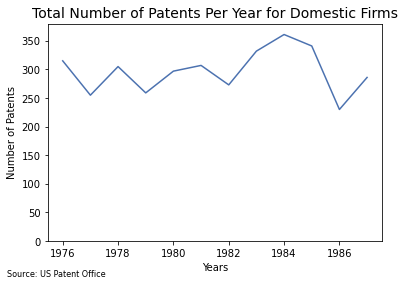

In [127]:
#line graph (x,y,data)
sns.lineplot('years','num_pats',data=patents_by_year,color='#4C72B0')
plt.xlabel('Years')
plt.ylabel('Number of Patents')
plt.title('Total Number of Patents Per Year for Domestic Firms',fontsize=14)

#finiky bits
plt.ylim(0, 380)

#caption
txt = "Source: US Patent Office"
plt.figtext(0.26, 0.001, txt, wrap=True, horizontalalignment='right', fontsize=8)
#https://stackoverflow.com/questions/34010205/adding-caption-below-x-axis-for-a-scatter-plot-using-matplotlib

#save fig
plt.savefig('patents_by_year_line_api', dpi = 300)

### Graph 2: Total Number of Patents by Year for All Firms

In [134]:
#number of patents by year

select = firms[['years','num_pats','domestic']]
select

patents_by_year = select[['years','num_pats','domestic']].groupby(['years','domestic']).sum().drop_duplicates().reset_index()
patents_by_year

years  domestic  num_pats
0    1976         0       420
1    1976         1       315
2    1977         0       436
3    1977         1       255
4    1978         0       616
5    1978         1       305
6    1979         0       499
7    1979         1       259
8    1980         0       586
9    1980         1       297
10   1981         0       559
11   1981         1       307
12   1982         0       615
13   1982         1       273
14   1983         0       723
15   1983         1       332
16   1984         0       984
17   1984         1       361
18   1985         0      1061
19   1985         1       341
20   1986         0       810
21   1986         1       230
22   1987         0       972
23   1987         1       286

C:\Users\Gabrielle Martinez\AppData\Roaming\Python\Python38\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


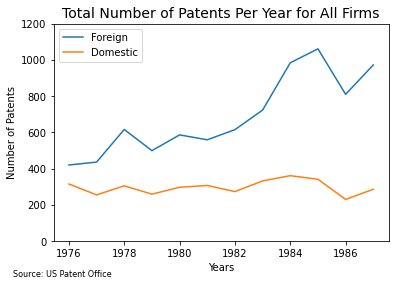

In [147]:
#line graph (x,y,data)
sns.lineplot('years','num_pats', data=patents_by_year, hue='domestic')
plt.xlabel('Years')
plt.ylabel('Number of Patents')
plt.title('Total Number of Patents Per Year for All Firms',fontsize=14)

#finiky bits - editing y axis
plt.ylim(0, 1200)

#add legend
# plt.legend(bbox_to_anchor=(1.2, 1.02), loc='upper right')
plt.legend(loc='upper left', labels=['Foreign', 'Domestic'])
#https://stackoverflow.com/questions/45201514/edit-seaborn-legend

#caption
txt = "Source: US Patent Office"
plt.figtext(0.26, 0.001, txt, wrap=True, horizontalalignment='right', fontsize=8)

#save fig
plt.savefig('patents_all_firms_line', dpi = 300)

### Graph 3: Fuel Prices by Year

In [151]:
#fuel price by year for new dataset
select = firms[['years','fuel_dollars_per_gallon']].dropna()
select

years  fuel_dollars_per_gallon
0      1980                     1.28
1      1982                     1.31
3      1977                     0.65
4      1983                     1.17
23     1984                     1.12
...     ...                      ...
2866   1983                     1.14
2867   1981                     1.33
2869   1984                     1.14
2870   1985                     1.14
2871   1986                     0.85

[1338 rows x 2 columns]

C:\Users\Gabrielle Martinez\AppData\Roaming\Python\Python38\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


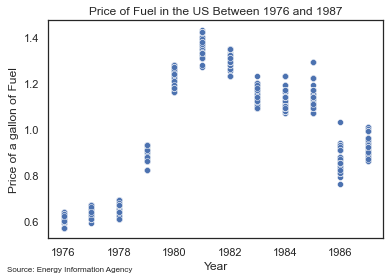

In [179]:
#line graph
sns.scatterplot('years','fuel_dollars_per_gallon', data=select)
plt.xlabel('Year')
plt.ylabel('Price of a gallon of Fuel')
plt.title('Price of Fuel in the US Between 1976 and 1987')

#caption
txt = "Source: Energy Information Agency"
plt.figtext(0.32, 0.01, txt, wrap=True, horizontalalignment='right', fontsize=8)

#save fig
plt.savefig('fuel_by_year_scatterplot', dpi = 300)

## Part 4: Regressions
All regressions were done and analyzed in the R Jupyter Notebook (`Gabrielle Martinez - R.ipynb`)
### End of Python Notebook